In [ ]:
%pip install synthcity[all]
%pip install catenets
%pip install captum
%pip install diffprivlib
%pip install opacus

In [1]:
from synthcity.plugins import Plugins
from synthcity.metrics.eval_statistical import AlphaPrecision, InverseKLDivergence, MaximumMeanDiscrepancy, WassersteinDistance
from synthcity.metrics.eval_privacy import *
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils.serialization import save_to_file, load_from_file
import matplotlib.pyplot as plt
import pandas as pd
from catenets.models.torch import *
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from sklearn.preprocessing import OneHotEncoder
from captum.attr import *
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import multivariate_normal
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from synthcity.plugins.core.constraints import Constraints
import random
from OneClass import OneClassLayer
from diffprivlib.models import LogisticRegression as LogisticRegressionDP
from diffprivlib.models import RandomForestClassifier as RandomForestClassifierDP
from opacus import PrivacyEngine
from CATENets_dp.catenets_dp.models.torch import TLearner as TLearnerDP
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics



[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warn

In [2]:
def train_models(gen_list, datasets, n_runs):
    for g in gen_list:
        for dataset in datasets:
            for i in range(n_runs):
                print(f'Training model {g} iteration {i} on dataset {dataset}')
                model = Plugins().get(g)
                model.fit(datasets[dataset])
                fp = 'models/' + g + '_' + dataset + '_' + str(i) + '.pkl'
                print(f'Saving model {g} iteration {i} on dataset {dataset}')
                save_to_file(fp, model)

In [3]:
def generate_data(models, n):
    for fp in models:
        g = load_from_file('models/' + fp)
        df = g.generate(count = n).dataframe()

        name_list = fp.split('.')
        name = name_list[0]
        df.to_csv('syn_data/' + name + '.csv', index=False)

In [4]:
def get_CATE_PEHE(datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = pd.DataFrame(columns=['generator', 'learner', 'rmse'])
    for d in datasets:
        dataset = datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])  
        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            pred = learner.predict(X_t)
            cate = mu1 - mu0
            rmse = mean_squared_error(cate, pred, squared = False)
            results.loc[len(results.index)] = [d, learner.__str__(), rmse]
            print(f'{learner} complete on {d}')

    return results

In [5]:
def get_CATE_estimates(training_datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = X_t.copy()
    results = pd.concat([results, mu0, mu1], axis=1)
    results['CATE'] = results['mu1'] - results['mu0']

    for d in training_datasets:
        dataset = training_datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])

        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            X_t_array = np.array(X_t)
            pred = learner.predict(X_t_array)
            col = d.split('.')[0] + '_' + learner.__str__()
            results[col] = pred
        
            print(f'{learner} complete on {d}')
            
    return results

In [6]:
def rate_of_flipping(d, cols):
    rates = pd.DataFrame()
    for c in cols:
        m = d['CATE'] * d[c]
        wrong = sum(m<0)
        rate = wrong / d.shape[0]
        rates[c] = [rate]
    rates = rates.transpose()
    return rates

In [7]:
def standard_metrics(datasets, real, metrics):
    results = pd.DataFrame(columns = ['dataset', 'metric', 'result'])
    for d in datasets:
        dataset = GenericDataLoader(datasets[d])
        for m in metrics:
            metric = metrics[m]
            result = metric.evaluate(real, dataset)
            for r in result:
                results.loc[len(results.index)] = [d, r, result[r]]
    
    return results

In [8]:
def encode_acic_datasets(real, syn_data):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)

    syn_data_encoded = {}
    for d in syn_data:
        syn_dataset = syn_data[d]
        encoded = encoder.transform(syn_dataset[categorical])
        encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
        syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
        syn_encoded.drop(categorical, axis=1, inplace=True)
        syn_data_encoded[d] = syn_encoded
    
    return real_encoded, syn_data_encoded

In [9]:
def encode_acic(real, syn_dataset):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)
    encoded = encoder.transform(syn_dataset[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
    syn_encoded.drop(categorical, axis=1, inplace=True)
    return real_encoded, syn_encoded

In [10]:
def encode(real):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)
    return real_encoded

## New metrics

In [11]:
def evaluate_f(real, synth, treatment_col, outcome_col):
    alpha = AlphaPrecision(random_state = random.randint(0, 1000000))

    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    synth_cov = synth.drop([treatment_col, outcome_col], axis=1)

    f = alpha.evaluate(GenericDataLoader(real_cov), GenericDataLoader(synth_cov))['delta_precision_alpha_OC']

    return f

In [12]:
def evaluate_c(real, synth, treatment_col, outcome_col):
    alpha = AlphaPrecision(random_state = random.randint(0, 1000000))

    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    synth_cov = synth.drop([treatment_col, outcome_col], axis=1)

    c = alpha.evaluate(GenericDataLoader(real_cov), GenericDataLoader(synth_cov))['delta_coverage_beta_OC']

    return c

In [13]:
def propensity_distance(p_real, p_synth):
    return 1 - abs(p_synth - p_real) / max(p_real, 1-p_real)

In [14]:
def train_propensity_function(real, treatment_col, outcome_col):
    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[treatment_col])
    classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    classifier.fit(X, y)

    return classifier

In [15]:
def get_d_max(props):
    propensities_max = [0 if i >= 0.5 else 1 for i in props]

    return mean_squared_error(props, propensities_max, squared=False)

In [16]:
def evaluate_d(real, synth, treatment_col, outcome_col):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    pi_real = train_propensity_function(real, treatment_col, outcome_col)
    pi_synth = train_propensity_function(synth, treatment_col, outcome_col)

    probabilities_real = pi_real.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_real = probabilities_real[:, 1]

    probabilities_synth = pi_synth.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_synth = probabilities_synth[:, 1]

    d_max = get_d_max(propensities_real)

    return 1 - mean_squared_error(propensities_real, propensities_synth, squared=False)/d_max

In [17]:
def cosine_average_first(v1, v2):
    return cosine_similarity(v1.sum(axis=0).reshape(1,-1), v2.sum(axis=0).reshape(1,-1))[0][0]

In [18]:
def evaluate_u_int(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]


    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    ig_real = IntegratedGradients(l_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    attr_real = ig_real.attribute(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    ig_synth = IntegratedGradients(l_synth)
    attr_synth = ig_synth.attribute(X_t)

    first = cosine_average_first(attr_real, attr_synth)
    return first

In [19]:
def evaluate_u_pehe(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
    return pehe

In [20]:
def evaluate_average_u_pehe(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    real_learners = [TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=False,seed=random.randint(0,1000000))]
    synth_learners = [TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=False,seed=random.randint(0,1000000))]

    avg_pehe = 0
    for i in range(len(real_learners)):
        l_real = real_learners[i]
        l_synth = synth_learners[i]
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)
        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
        y_synth = np.array(synth[outcome_col])
        w_synth = np.array(synth[treatment_col])
        l_synth.fit(X_synth, y_synth, w_synth)
        pred_synth = l_synth.predict(X_t)

        pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
        avg_pehe += pehe

    return avg_pehe / len(real_learners)

In [21]:
def evaluate_u_policy(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pred_mult = pd.DataFrame(pred_real * pred_synth)
    num_pos = len(pred_mult[pred_mult[0]>0])
    correct_rate = num_pos / len(pred_real)

    return correct_rate

In [22]:
def evaluate_average_u_policy(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    real_learners = [TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=False,seed=random.randint(0,1000000))]
    synth_learners = [TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), 
                DRLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000)), RALearner(n_unit_in=n_units, binary_y=False,seed=random.randint(0,1000000))]

    avg_correct_rate = 0
    for i in range(len(real_learners)):
        l_real = real_learners[i]
        l_synth = synth_learners[i]
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)
        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
        y_synth = np.array(synth[outcome_col])
        w_synth = np.array(synth[treatment_col])
        l_synth.fit(X_synth, y_synth, w_synth)
        pred_synth = l_synth.predict(X_t)

        pred_mult = pd.DataFrame(pred_real * pred_synth)
        num_pos = len(pred_mult[pred_mult[0]>0])
        correct_rate = num_pos / len(pred_real)
        avg_correct_rate += correct_rate
        #print(f'{l_synth.__str__()} PEHE: {pehe}')

    return avg_correct_rate / len(real_learners)

In [23]:
def generate_sequentially_to_w(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()

    #generate covariates
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    print(f'Fitting {gen} covariate model')
    g.fit(real_cov)
    print(f'Generating {gen} synthetic covariates')
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    
    if private:
        classifier = LogisticRegressionDP(random_state = random.randint(0, 1000000), epsilon=epsilon)
    else:
        classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    print('Fitting propensity model')
    classifier.fit(X, y)
    print('Generating propensities')
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)

    synth_cov_with_prop = syn_encoded
    synth_cov_with_prop[treatment_col] = pd.Series(binary_outcomes)

    synth_cov_with_prop[outcome_col] = 0

    return synth_cov_with_prop

In [34]:
def generate_sequentially(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()
    synth = generate_sequentially_to_w(real, gen, treatment_col, outcome_col, encode=encode, private=private, epsilon=epsilon, delta=delta)

    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[outcome_col])
    w = np.array(real[treatment_col])
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    if private:
        l = TLearnerDP(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting private CATE learner')
        l.fit(X, y, w, epsilon=epsilon, delta=delta)
    else:
        l = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting CATE learner')
        l.fit(X, y, w)

    seq_X = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    print('Generating POs')
    cate, y0, y1 = l.predict(seq_X, return_po=True)

    outcomes = []
    for index, value in synth[treatment_col].iteritems():
        if value == 0:
            outcomes.append(y0[index].item())
        else:
            outcomes.append(y1[index].item())

    synth[outcome_col] = outcomes
    return synth

In [25]:
def generate_standard(real, gen, private=False, epsilon=None, delta=None):
    random.seed()
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    print(f'Fitting {gen} model')
    g.fit(real)
    print(f'Generating {gen} synthetic dataset')
    synth = g.generate(count = len(real)).dataframe()
    return synth

In [26]:
def seq_test(real, gen, treatment_col, outcome_col, n_iter, encode=False, private=False, epsilon=None, delta=None, save=False, fp=''):
    results = pd.DataFrame(columns = ['method', 'f', 'c', 'd', 'u_pehe', 'u_policy', 'u_int'])
    for _ in range(n_iter):
        stand = generate_standard(real, gen, private=private, epsilon=epsilon, delta=delta)
        seq_new = generate_sequentially(real, gen, treatment_col, outcome_col, encode=encode, private=private, epsilon=epsilon, delta=delta)
        n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
        
        if encode:
            real_encoded, stand_encoded = encode_acic(real, stand)
            _, seq_encoded = encode_acic(real, seq_new)
        else:
            real_encoded = real
            stand_encoded = stand
            seq_encoded = seq_new

        results.loc[len(results)] = ['standard', evaluate_f(real_encoded, stand_encoded, treatment_col, outcome_col), evaluate_c(real_encoded, stand_encoded, treatment_col, outcome_col), 
                                     evaluate_d(real_encoded, stand_encoded, treatment_col, outcome_col), evaluate_average_u_pehe(real_encoded, stand_encoded, treatment_col, outcome_col, n_units), 
                                     evaluate_u_policy(real_encoded, stand_encoded, treatment_col, outcome_col, n_units), evaluate_u_int(real_encoded, stand_encoded, treatment_col, outcome_col, n_units)]
        results.loc[len(results)] = ['seq_new', evaluate_f(real_encoded, seq_encoded, treatment_col, outcome_col), evaluate_c(real_encoded, seq_encoded, treatment_col, outcome_col), 
                                     evaluate_d(real_encoded, seq_encoded, treatment_col, outcome_col), evaluate_average_u_pehe(real_encoded, seq_encoded, treatment_col, outcome_col, n_units), 
                                     evaluate_u_policy(real_encoded, seq_encoded, treatment_col, outcome_col, n_units), evaluate_u_int(real_encoded, seq_encoded, treatment_col, outcome_col, n_units)]
    if save:
        results.to_csv(fp, index=False)
    
    return results


In [27]:
def u_pehe_test(real, gen, treatment_col, outcome_col, n_iter, encode=False, save=False, fp=''):
    results = pd.DataFrame(columns = ['method', 'u_pehe'])
    for _ in range(n_iter):
        stand = generate_standard(real, gen)
        seq_new = generate_sequentially(real, gen, treatment_col, outcome_col, encode=encode)
        n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
        
        if encode:
            real_encoded, stand_encoded = encode_acic(real, stand)
            _, seq_encoded = encode_acic(real, seq_new)
        else:
            real_encoded = real
            stand_encoded = stand
            seq_encoded = seq_new

        results.loc[len(results)] = ['standard', evaluate_average_u_pehe(real_encoded, stand_encoded, treatment_col, outcome_col, n_units)]
        results.loc[len(results)] = ['seq_new', evaluate_average_u_pehe(real_encoded, seq_encoded, treatment_col, outcome_col, n_units)]
    if save:
        results.to_csv(fp, index=False)
    
    return results

## Load real datasets

In [28]:
ihdp_full = pd.read_csv('../Datasets/ihdp.csv')
ihdp = ihdp_full.drop(['y_cfactual', 'mu0', 'mu1'], axis=1)
ihdp['treatment'] = ihdp['treatment'].astype(int)
#train on 80% of the data, the remaining 20% for testing of CATE estimators
train_ihdp = ihdp.loc[[i for i in range(600)]]
test_ihdp = ihdp.loc[[i+600 for i in range(147)]]

In [44]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [134]:
twins = pd.read_csv('../Datasets/twins.csv')

In [278]:
acic_full = pd.read_csv('../Datasets/acic.csv')
acic_full['y'] = acic_full['y0']
acic_full.loc[acic_full['z']==1, 'y'] = acic_full.loc[acic_full['z']==1, 'y1']

acic = acic_full.drop(['y0', 'y1', 'mu0', 'mu1'], axis=1)
acic_train = acic.loc[[i for i in range(4000)]]
acic_test = acic.loc[[i+4000 for i in range(802)]]
acic_encoded = encode(acic)

## New generation ideas

### Training a generator for each treatment group

In [406]:
def train_models_separate(gen_list, datasets, n_runs, treatment_cols):
    j=0

    for g in gen_list:
        for d in datasets:
            treatment_col = treatment_cols[j]

            dataset = datasets[d]
            dataset_0 = dataset[dataset[treatment_col] == 0].drop(treatment_col, axis=1)
            dataset_1 = dataset[dataset[treatment_col] == 1].drop(treatment_col, axis=1)

            for i in range(n_runs):

                print(f'Training model {g} iteration {i} on dataset {d} treatment 0')
                model = Plugins().get(g)
                model.fit(dataset_0)
                fp = 'separate_models/' + g + '_' + d + '0_' + str(i) + '.pkl'
                save_to_file(fp, model)

                print(f'Training model {g} iteration {i} on dataset {d} treatment 1')
                model = Plugins().get(g)
                model.fit(dataset_1)
                fp = 'separate_models/' + g + '_' + d + '1_' + str(i) + '.pkl'
                save_to_file(fp, model)
        j += 1

In [419]:
def generate_data_separate(model0, model1, pi, n, treatment_col):
    n_1 = round(n*pi)
    n_0 = n - n_1

    g_0 = load_from_file('separate_models/' + model0)
    g_1 = load_from_file('separate_models/' + model1)
    df_0 = g_0.generate(count = n_0).dataframe()
    df_0[treatment_col] = 0
    df_1 = g_1.generate(count = n_1).dataframe()
    df_1[treatment_col] = 1

    df = pd.concat([df_0, df_1])

    model0 = model0.split('.')[0]
    name_list = model0.split('_')
    name = name_list[0] + '_' + name_list[1][:-1] + '_' + name_list[2]
    df.to_csv('syn_data_separate/' + name + '_separate.csv', index=False)

In [324]:
def gen_sep(real, gen, treatment_col):
    dataset_0 = real[real[treatment_col] == 0].drop(treatment_col, axis=1)
    dataset_1 = real[real[treatment_col] == 1].drop(treatment_col, axis=1)
    n = len(real)
    pi = sum(real[treatment_col]) / n
    n_1 = round(n*pi)
    n_0 = n - n_1
    g_0 = Plugins().get(gen)
    g_0.fit(dataset_0)
    g_1 = Plugins().get(gen)
    g_1.fit(dataset_1)
    df_0 = g_0.generate(count = n_0).dataframe()
    df_0[treatment_col] = 0
    df_1 = g_1.generate(count = n_1).dataframe()
    df_1[treatment_col] = 1
    df = pd.concat([df_0, df_1])

    return df

In [351]:
m = 1

X_0 = pd.DataFrame(np.random.normal(loc = m, size=(2000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(2000,20)))
X_0['w'] = 0
X_1['w'] = 1
d = pd.concat([X_0, X_1], axis=0)
d['y'] = np.random.normal(loc = 0, size=(4000,1))

In [352]:
synth_sep = gen_sep(d, 'ctgan', 'w')

[2024-04-30T07:45:40.868909+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:45:40.869464+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:45:40.869947+0000][4191568][CRITICAL] module plugin_goggle load failed
 42%|████▏     | 849/2000 [02:59<04:03,  4.73it/s]
[2024-04-30T07:48:47.132985+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:48:47.133526+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:48:47.133968+0000][4191568][CRITICAL] module plugin_goggle load failed
 27%|██▋       | 549/2000 [01:54<05:02,  4.79it/s]


In [353]:
synth = generate_standard(d, 'ctgan')

[2024-04-30T07:50:48.657028+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:50:48.658350+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:50:48.658777+0000][4191568][CRITICAL] module plugin_goggle load failed
 27%|██▋       | 549/2000 [04:42<12:26,  1.94it/s]


In [356]:
evaluate_d(d, synth_sep, 'w', 'y')

0.002374114615312479

In [357]:
evaluate_d(d, synth, 'w', 'y')

0.014232456084814337

In [427]:
gen_list = ['ddpm']
datasets = {}
datasets['acic'] = acic

In [428]:
train_models_separate(gen_list, datasets, 1, ['z'])

[2024-04-29T04:10:11.992729+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:10:11.993217+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:10:11.993525+0000][3754226][CRITICAL] module plugin_goggle load failed


Training model ddpm iteration 0 on dataset acic treatment 0


Epoch: 100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s, loss=0.876]
[2024-04-29T04:11:45.183756+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:11:45.184238+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:11:45.184579+0000][3754226][CRITICAL] module plugin_goggle load failed


Training model ddpm iteration 0 on dataset acic treatment 1


Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s, loss=1.26]


In [426]:
sum(acic['z'])/len(acic)

0.17867555185339443

In [429]:
generate_data_separate('ddpm_acic0_0.pkl', 'ddpm_acic0_0.pkl', 0.179, 747, 'treatment')

In [430]:
separate = pd.read_csv('syn_data_separate/ddpm_acic_0_separate.csv')

In [434]:
separate = separate.rename(columns = {'treatment':'z'})

### Generation in a sequential manner, mimicing the true DGP

Given a real dataset $D = [X, W, Y]$, will train a generative model only on the covariates $X$. Then will predict the treatment assignment $W$ based on the propensity score $\pi(x)$ for each instance, where $\pi(.)$ is learnt from the real dataset. Then, will generate the outcomes $Y$ based on a conditional generative model that has been trained on $D$.

In [279]:
results = seq_test(acic_encoded, 'ddpm', 'z', 'y', 5, save=True, fp='acic_sequential_vs_standard_ddpm_2.csv')

[2024-05-14T16:22:34.205821+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:22:34.206825+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:22:34.207260+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [02:49<00:00,  5.91it/s, loss=0.744]


Generating ddpm synthetic dataset


[2024-05-14T16:26:42.221936+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:26:42.223134+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:26:42.223514+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s, loss=0.747]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T16:40:54.470380+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:40:54.474044+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:40:54.474709+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [02:47<00:00,  5.98it/s, loss=0.785]


Generating ddpm synthetic dataset


[2024-05-14T16:44:59.999545+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:45:00.000921+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:45:00.001487+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s, loss=0.748]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T16:58:34.021500+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:58:34.024979+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T16:58:34.025642+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s, loss=0.75]


Generating ddpm synthetic dataset


[2024-05-14T17:02:36.098963+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:02:36.099993+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:02:36.100308+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s, loss=0.751]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T17:16:14.962675+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:16:14.966001+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:16:14.966546+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [02:46<00:00,  6.02it/s, loss=0.739]


Generating ddpm synthetic dataset


[2024-05-14T17:20:19.529456+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:20:19.530593+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:20:19.531086+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s, loss=0.746]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T17:34:45.793291+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:34:45.796865+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:34:45.797782+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s, loss=0.74]


Generating ddpm synthetic dataset


[2024-05-14T17:38:47.228844+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:38:47.229782+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:38:47.230180+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [02:41<00:00,  6.17it/s, loss=0.738]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [280]:
results_tvae = seq_test(acic_encoded, 'tvae', 'z', 'y', 5, save=True, fp='acic_sequential_vs_standard_tvae_2.csv')

[2024-05-14T17:53:25.474583+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:53:25.475588+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:53:25.475924+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 30%|███       | 300/1000 [05:48<13:32,  1.16s/it]


Generating tvae synthetic dataset


[2024-05-14T17:59:24.810587+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:59:24.811321+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T17:59:24.811752+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae covariate model


 30%|███       | 300/1000 [05:45<13:26,  1.15s/it]


Generating tvae synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T18:14:32.906989+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:14:32.910364+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:14:32.911394+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 30%|███       | 300/1000 [05:42<13:19,  1.14s/it]


Generating tvae synthetic dataset


[2024-05-14T18:20:26.944243+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:20:26.945028+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:20:26.945463+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae covariate model


 30%|███       | 300/1000 [05:31<12:53,  1.11s/it]


Generating tvae synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T18:35:09.160791+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:35:09.161526+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:35:09.162122+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 30%|███       | 300/1000 [05:48<13:32,  1.16s/it]


Generating tvae synthetic dataset


[2024-05-14T18:41:08.111344+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:41:08.112165+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:41:08.112659+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae covariate model


 30%|███       | 300/1000 [05:52<13:42,  1.17s/it]


Generating tvae synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T18:56:26.188077+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:56:26.190400+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T18:56:26.190933+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 30%|███       | 300/1000 [05:53<13:45,  1.18s/it]


Generating tvae synthetic dataset


[2024-05-14T19:02:31.058313+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:02:31.059143+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:02:31.059588+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae covariate model


 30%|███       | 300/1000 [05:48<13:33,  1.16s/it]


Generating tvae synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T19:17:52.107124+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:17:52.107858+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:17:52.108239+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 30%|███       | 300/1000 [06:02<14:05,  1.21s/it]


Generating tvae synthetic dataset


[2024-05-14T19:24:06.049872+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:24:06.051048+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:24:06.051656+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting tvae covariate model


 35%|███▌      | 350/1000 [06:55<12:52,  1.19s/it]


Generating tvae synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [281]:
results_ctgan = seq_test(acic_encoded, 'ctgan', 'z', 'y', 5, save=True, fp='acic_sequential_vs_standard_ctgan_2.csv')

[2024-05-14T19:40:23.508943+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:40:23.510301+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:40:23.510715+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 35%|███▍      | 699/2000 [15:36<29:02,  1.34s/it]  


Generating ctgan synthetic dataset


[2024-05-14T19:56:11.434570+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:56:11.435336+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T19:56:11.435817+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan covariate model


 42%|████▏     | 849/2000 [19:07<25:55,  1.35s/it]  


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T20:24:43.678059+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T20:24:43.681740+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T20:24:43.682186+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 30%|██▉       | 599/2000 [13:42<32:04,  1.37s/it]  


Generating ctgan synthetic dataset


[2024-05-14T20:38:37.597752+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T20:38:37.598656+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T20:38:37.599162+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan covariate model


 50%|████▉     | 999/2000 [22:19<22:21,  1.34s/it]  


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T21:10:05.574534+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T21:10:05.576722+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T21:10:05.577739+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 37%|███▋      | 749/2000 [16:52<28:11,  1.35s/it]  


Generating ctgan synthetic dataset


[2024-05-14T21:27:09.924588+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T21:27:09.925269+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T21:27:09.925716+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan covariate model


 52%|█████▏    | 1049/2000 [22:33<20:27,  1.29s/it] 


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T21:59:02.942601+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T21:59:02.946995+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T21:59:02.947665+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 40%|███▉      | 799/2000 [17:35<26:25,  1.32s/it]  


Generating ctgan synthetic dataset


[2024-05-14T22:16:49.147685+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T22:16:49.148376+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T22:16:49.148730+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan covariate model


 57%|█████▋    | 1149/2000 [25:22<18:47,  1.32s/it] 


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-14T22:51:40.641786+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T22:51:40.642833+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T22:51:40.643284+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 27%|██▋       | 549/2000 [12:34<33:14,  1.37s/it]  


Generating ctgan synthetic dataset


[2024-05-14T23:04:26.737249+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:04:26.738261+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:04:26.738957+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting ctgan covariate model


 15%|█▍        | 299/2000 [06:47<38:37,  1.36s/it]  


Generating ctgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [98]:
results = pd.read_csv('acic_sequential_vs_standard_tvae_avg.csv')

In [101]:
results.groupby('method').mean()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.758701,0.515838,0.963163,2.162760,0.964792,-0.156712
standard,0.781902,0.518853,0.922269,4.047876,0.633125,-0.030681


In [102]:
results.groupby('method').std() / np.sqrt(5) * 1.96

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.014389,0.007743,0.005599,0.251443,0.004584,0.147712
standard,0.022983,0.012270,0.009513,0.098481,0.075180,0.161490


In [188]:
results_tvae.groupby('method').mean()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.758701,0.515838,0.963163,2.162760,0.964792,-0.156712
standard,0.781902,0.518853,0.922269,4.047876,0.633125,-0.030681


In [159]:
results_tvae.groupby('method').std()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.016416,0.008833,0.006387,0.286859,0.005229,0.168517
standard,0.026220,0.013999,0.010853,0.112352,0.085770,0.184236


In [160]:
results_ctgan.groupby('method').mean()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.869298,0.436882,0.967178,2.289130,0.967083,0.199079
standard,0.877918,0.433569,0.906551,4.450897,0.558750,0.038587


In [161]:
results_ctgan.groupby('method').std()

,f,c,d,u_pehe,u_policy,u_int
method,,,,,,
seq_new,0.035122,0.018883,0.005114,0.472164,0.006362,0.407908
standard,0.042579,0.030014,0.028165,0.439662,0.062168,0.194385


### Insights

How does altering the size of $D_\text{real}$ affect the performance difference between standard and sequential generation?

In [273]:
X,y,w,p,t = simulate_treatment_setup(200, d=10, n_o=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [274]:
test_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:31:39.097615+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:39.098649+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:39.099041+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.36it/s, loss=0.989]
[2024-05-03T02:31:50.969285+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:50.969945+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:50.970408+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:04<00:00, 217.33it/s, loss=0.386]
[2024-05-03T02:33:20.888257+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has n

In [275]:
test_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.015315,0.770233,4.121382,0.691667,0.719221
standard,0.002097,0.716804,9.071507,0.666667,0.316862


In [271]:
test.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.360417,0.88249,2.100155,0.93,0.927594
standard,0.152567,0.82901,7.167894,0.94,-0.003107


In [272]:
test

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.167027,0.867223,6.095212,0.955,0.072566
1,seq_new,0.439605,0.887411,2.238435,0.940,0.902416
2,standard,0.147813,0.832681,7.002279,0.890,0.150050
3,seq_new,0.333976,0.890791,1.966447,0.920,0.959688
4,standard,0.142860,0.787125,8.406189,0.975,-0.231937
5,seq_new,0.307669,0.869267,2.095585,0.930,0.920677


How does altering the complexity of $\pi$, aka the number of confounding, change the performance delta

In [292]:
X,y,w,p,t = simulate_treatment_setup(500, d=10, n_c=0, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [293]:
test_no_conf = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:41:49.165677+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:41:49.167369+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:41:49.167746+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 106.30it/s, loss=0.874]
[2024-05-03T02:42:02.367143+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:42:02.367865+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:42:02.368231+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:05<00:00, 172.63it/s, loss=0.445]
[2024-05-03T02:43:03.426300+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has n

In [294]:
test_no_conf.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.129772,0.821495,1.642043,0.756667,0.945134
standard,0.040088,0.820911,5.189636,0.716667,0.621149


In [295]:
X,y,w,p,t = simulate_treatment_setup(500, d=10, n_c=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [296]:
test_conf = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:45:15.541286+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:15.541946+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:15.542539+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 102.82it/s, loss=0.94]
[2024-05-03T02:45:28.928814+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:28.929577+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:28.930003+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:05<00:00, 172.85it/s, loss=0.445]
[2024-05-03T02:47:16.612714+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

In [308]:
test_conf

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.022478,0.703656,14.005186,0.87,0.617082
1,seq_new,0.113149,0.893558,2.330140,1.00,0.882679
2,standard,0.026847,0.738174,14.396672,0.97,0.608709
3,seq_new,0.106421,0.896517,2.045986,0.98,0.944349
4,standard,0.023043,0.786037,9.014050,0.98,0.424975
5,seq_new,0.076220,0.886541,2.258104,0.99,0.950160


In [62]:
def confounding_insight(n, d, n_t, n_cs, gen, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'f', 'c', 'd', 'u_pehe', 'u_policy', 'u_int', 'n_c'])
    for n_c in n_cs:
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        r = seq_test(d_real, gen, 'w', 'y', n_iter)
        r['n_c'] = n_c
        results = pd.concat([results, r])
        print(f'Tested n_c = {n_c}')

    if save:
        results.to_csv(fp, index=False)
        
    return results

In [64]:
conf_results = confounding_insight(1000, 15, 5, [1,2,3,4,5,6,7,8,9,10], 'ddpm', 2)#, save=True, fp = 'confounding_insight_new.csv')

[2024-05-09T05:00:44.651238+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:00:44.651782+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:00:44.652180+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.16it/s, loss=0.876]
[2024-05-09T05:01:00.788366+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:01:00.789311+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:01:00.789649+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.74it/s, loss=0.471]
[2024-05-09T05:02:29.114690+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

Tested n_c = 1


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.00it/s, loss=0.881]
[2024-05-09T05:04:25.415847+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:04:25.416460+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:04:25.416843+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.00it/s, loss=0.472]
[2024-05-09T05:06:05.106968+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:06:05.109812+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:06:05.110382+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.65it/s, loss=0.9] 
[2024-05-09T05:06:20.782233+0000][2265347][CRITICAL

Tested n_c = 2


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.88it/s, loss=0.91]
[2024-05-09T05:08:12.178072+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:08:12.178648+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:08:12.178992+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.81it/s, loss=0.468]
[2024-05-09T05:10:06.413243+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:10:06.415778+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:10:06.416848+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.06it/s, loss=0.905]
[2024-05-09T05:10:22.510076+0000][2265347][CRITICAL

Tested n_c = 3


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.88it/s, loss=0.91]
[2024-05-09T05:12:37.921661+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:12:37.922461+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:12:37.922931+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.30it/s, loss=0.471]
[2024-05-09T05:14:43.938169+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:14:43.940307+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:14:43.941298+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 79.30it/s, loss=0.919]
[2024-05-09T05:15:00.332718+0000][2265347][CRITICAL

Tested n_c = 4


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.59it/s, loss=0.939]
[2024-05-09T05:17:24.375161+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:17:24.375836+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:17:24.376278+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.08it/s, loss=0.469]
[2024-05-09T05:19:31.718230+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:19:31.720462+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:19:31.721477+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.28it/s, loss=0.94]
[2024-05-09T05:19:47.320442+0000][2265347][CRITICAL

Tested n_c = 5


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.83it/s, loss=0.961]
[2024-05-09T05:22:08.070560+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:22:08.071794+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:22:08.072217+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.61it/s, loss=0.47]
[2024-05-09T05:24:21.955746+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:24:21.959074+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:24:21.959678+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.82it/s, loss=0.964]
[2024-05-09T05:24:37.261918+0000][2265347][CRITICAL

Tested n_c = 6


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.37it/s, loss=0.973]
[2024-05-09T05:27:07.488862+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:27:07.489679+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:27:07.490153+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 113.84it/s, loss=0.469]
[2024-05-09T05:29:44.584957+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:29:44.587195+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:29:44.588213+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.42it/s, loss=0.965]
[2024-05-09T05:30:00.375615+0000][2265347][CRITICA

Tested n_c = 7


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.95it/s, loss=0.988]
[2024-05-09T05:32:47.928648+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:32:47.929320+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:32:47.929743+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.79it/s, loss=0.47]
[2024-05-09T05:35:28.290208+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:35:28.292720+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:35:28.293844+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.49it/s, loss=0.987]
[2024-05-09T05:35:43.678290+0000][2265347][CRITICAL

Tested n_c = 8


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.63it/s, loss=0.972]
[2024-05-09T05:38:38.411810+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:38:38.412603+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:38:38.412941+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.32it/s, loss=0.471]
[2024-05-09T05:41:30.840887+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:41:30.843246+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:41:30.844284+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.40it/s, loss=0.969]
[2024-05-09T05:41:46.232718+0000][2265347][CRITICA

Tested n_c = 9


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.66it/s, loss=0.996]
[2024-05-09T05:44:53.539250+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:44:53.540319+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:44:53.540705+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.32it/s, loss=0.47]
[2024-05-09T05:47:45.764111+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:47:45.767555+0000][2265347][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-09T05:47:45.768059+0000][2265347][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.30it/s, loss=1]   
[2024-05-09T05:48:00.870732+0000][2265347][CRITICAL]

Tested n_c = 10


In [65]:
conf_results.groupby(['n_c', 'method']).mean()

f         c         d     u_pehe  u_policy     u_int
n_c method                                                               
1   seq_new   0.571867  0.361967  0.898288   1.735367    0.9900  0.979436
    standard  0.301067  0.272733  0.811606   7.819979    0.9950  0.737268
2   seq_new   0.584067  0.387300  0.906842   1.819694    0.9750  0.960768
    standard  0.297700  0.260933  0.869077   9.289557    0.9675  0.764662
3   seq_new   0.627933  0.370767  0.917268   2.051066    0.9850  0.949069
    standard  0.197400  0.213867  0.801802   8.090952    0.9575  0.422187
4   seq_new   0.680933  0.430500  0.896328   2.207393    0.9700  0.913801
    standard  0.252200  0.250233  0.782999   7.335314    0.8875  0.176199
5   seq_new   0.625633  0.393667  0.923571   2.471355    0.9950  0.898546
    standard  0.280800  0.263400  0.833517   9.730895    0.9850  0.446926
6   seq_new   0.592600  0.367767  0.913660   2.418814    0.9750  0.828705
    standard  0.203633  0.193833  0.781289  13.431386    0.9725  0.497751
7   seq_new   0.637800  0.398467  0.901532   2.540632    0.9750  0.752279
    standard  0.161000  0.170467  0.771561  13.358511    0.9475  0.023714
8   seq_new   0.626733  0.405300  0.904361   2.505873    0.9850  0.818118
    standard  0.222467  0.236100  0.765633  15.217230    0.9700  0.256221
9   seq_new   0.640633  0.360000  0.910724   2.467514    0.9775  0.771144
    standard  0.163867  0.158167  0.781971  10.833029    0.8225  0.158609
10  seq_new   0.551100  0.374100  0.914829   3.169065    0.9750  0.758853
    standard  0.148367  0.171100  0.746026  22.392828    0.9750  0.396284

In [112]:
conf_results = pd.read_csv('confounding_insight_new.csv')

In [113]:
conf_results = conf_results[conf_results['n_c']!=0]

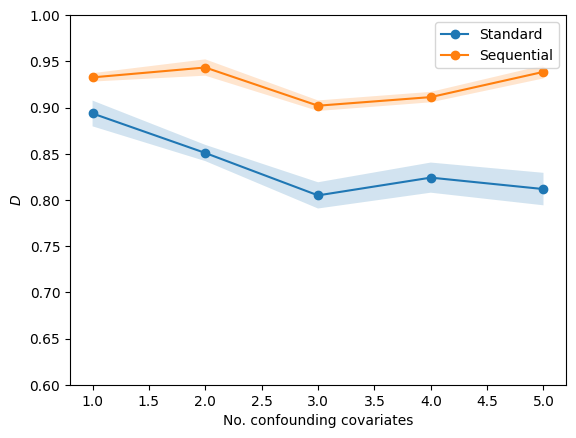

In [152]:
x = [1,2,3,4,5]
d_seq = conf_results[conf_results['method']=='seq_new'].groupby(['n_c']).mean()['d']
d_stand = conf_results[conf_results['method']=='standard'].groupby(['n_c']).mean()['d']

d_seq_std = conf_results[conf_results['method']=='seq_new'].groupby(['n_c']).std()['d'] / np.sqrt(10) * 1.96
d_stand_std = conf_results[conf_results['method']=='standard'].groupby(['n_c']).std()['d']/ np.sqrt(10) * 1.96


plt.plot(x, d_stand, 'o-', label = 'Standard')
plt.plot(x, d_seq, 'o-', label = 'Sequential')


plt.fill_between(x, d_stand - d_stand_std, d_stand + d_stand_std, alpha=0.2)
plt.fill_between(x, d_seq - d_seq_std, d_seq + d_seq_std, alpha=0.2)
plt.legend()
plt.xlabel('No. confounding covariates')
plt.ylabel('$D$')
plt.ylim([0.6,1])
plt.savefig('plots/confounding_complexity_plot.png')

What happens are num covariates increases?

In [300]:
X,y,w,p,t = simulate_treatment_setup(500, d=2, n_o=1, n_t=1)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [301]:
test_cov_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:56:02.472509+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:02.473777+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:02.474460+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 105.83it/s, loss=1.08]
[2024-05-03T02:56:15.610555+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:15.611305+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:15.611758+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:06<00:00, 165.80it/s, loss=0.471]
[2024-05-03T02:56:52.424485+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

In [302]:
test_cov_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.949355,0.948425,0.613462,0.756667,0.963520
standard,0.830259,0.914691,1.155762,0.506667,0.999829


What happens as number of predictive variables changes?

In [145]:
def predictive_insight(n, d, n_o, n_ts, gen, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'f', 'c', 'd', 'u_pehe', 'u_policy', 'u_int', 'n_t'])
    for n_t in n_ts:
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        r = seq_test(d_real, gen, 'w', 'y', n_iter)
        r['n_t'] = n_t
        results = pd.concat([results, r])

        print(f'Tested n_t = {n_t}')

    if save:
        results.to_csv(fp, index=False)
        
    return results

In [146]:
pred_results = predictive_insight(1000, 10, 5, [0,1,2,3,4,5], 'ddpm', 10, save=True, fp = 'predictive_insight_average.csv')

[2024-05-13T13:13:09.302883+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:09.303474+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:09.303832+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.24it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:13:25.110268+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:25.110835+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:13:25.111166+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.49it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:17:22.828150+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:22.830469+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:22.831508+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.33it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:17:38.191124+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:38.191684+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:17:38.192037+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.96it/s, loss=0.471]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:21:35.748460+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:35.751101+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:35.752081+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.33it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:21:51.009463+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:51.010236+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:21:51.010587+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.86it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:25:42.899887+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:42.902463+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:42.903429+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.51it/s, loss=1.17]


Generating ddpm synthetic dataset


[2024-05-13T13:25:58.127779+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:58.128445+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:25:58.128862+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.19it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:29:53.900123+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:29:53.901824+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:29:53.902321+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.95it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:30:09.178669+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:30:09.179225+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:30:09.179569+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.95it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:34:01.687731+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:01.690222+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:01.691170+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.93it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:34:17.121012+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:17.121574+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:34:17.121947+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.03it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:38:22.445999+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:22.448295+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:22.449353+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.71it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:38:38.056449+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:38.057047+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:38:38.057398+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.02it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:42:29.462114+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:29.464461+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:29.465413+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.28it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:42:44.749209+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:44.750007+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:42:44.750457+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.09it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:46:36.321978+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:36.325878+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:36.326890+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.32it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:46:52.114846+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:52.115507+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:46:52.115922+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.89it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:50:43.175291+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:43.177357+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:43.178444+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.17it/s, loss=1.18]


Generating ddpm synthetic dataset


[2024-05-13T13:50:58.708355+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:58.708946+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:50:58.709384+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.82it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:54:55.230244+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:54:55.231143+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:54:55.231576+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 0
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.20it/s, loss=1.17]


Generating ddpm synthetic dataset


[2024-05-13T13:55:10.391803+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:55:10.392384+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:55:10.392747+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.90it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T13:59:28.714400+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:28.718005+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:28.719081+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s, loss=1.15]


Generating ddpm synthetic dataset


[2024-05-13T13:59:44.424708+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:44.425647+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T13:59:44.425992+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.69it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:04:03.760474+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:03.762669+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:03.763629+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.13it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:04:19.148487+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:19.149206+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:04:19.149593+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.08it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:08:41.439460+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:41.441803+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:41.442815+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.14it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:08:57.458232+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:57.458814+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:08:57.459383+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.51it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:13:10.601571+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:10.604309+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:10.605264+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.04it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:13:26.152581+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:26.153144+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:13:26.153498+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.69it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:17:39.876723+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:39.879173+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:39.880146+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.49it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:17:54.993437+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:54.994076+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:17:54.994735+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.25it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:22:11.077252+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:11.081688+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:11.082264+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.40it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T14:22:26.610356+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:26.611172+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:22:26.611633+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.49it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:26:43.654661+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:43.657716+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:43.658738+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.96it/s, loss=1.16]


Generating ddpm synthetic dataset


[2024-05-13T14:26:58.789568+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:58.790360+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:26:58.790763+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.43it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:31:17.907033+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:17.909624+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:17.910780+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.85it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T14:31:32.933792+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:32.934360+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:31:32.934718+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.61it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:35:52.758793+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:35:52.761820+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:35:52.762373+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.34it/s, loss=1.15]


Generating ddpm synthetic dataset


[2024-05-13T14:36:08.113403+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:36:08.114002+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:36:08.114376+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 124.49it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:40:31.836129+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:31.837040+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:31.837399+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 1
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.71it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:40:47.292009+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:47.292617+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:40:47.292981+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.57it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:45:09.136772+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:09.139376+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:09.140381+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.63it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:45:24.784427+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:24.785147+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:45:24.785523+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.35it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:49:49.486781+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:49:49.489199+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:49:49.490178+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.25it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:50:04.983504+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:50:04.984090+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:50:04.984441+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.11it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:54:41.274027+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:41.276365+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:41.277284+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.67it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T14:54:56.759517+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:56.760087+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:54:56.760378+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.61it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T14:59:28.569030+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:28.571306+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:28.572331+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.37it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T14:59:44.545526+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:44.546285+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T14:59:44.546670+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.25it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:04:05.123619+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:05.125792+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:05.126793+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.77it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:04:20.157337+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:20.158309+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:04:20.158741+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.67it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:08:51.882476+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:08:51.883795+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:08:51.884312+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.16it/s, loss=1.13]


Generating ddpm synthetic dataset


[2024-05-13T15:09:07.051095+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:09:07.051699+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:09:07.052051+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.24it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:13:40.088254+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:40.089494+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:40.093732+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.10it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:13:55.513566+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:55.514247+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:13:55.514604+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.42it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:18:24.449623+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:24.451526+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:24.452547+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.53it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:18:39.935003+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:39.935887+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:18:39.936334+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.67it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:23:16.658666+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:16.660777+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:16.661753+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 88.02it/s, loss=1.14]


Generating ddpm synthetic dataset


[2024-05-13T15:23:31.672481+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:31.673146+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:23:31.673506+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.06it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:27:57.502601+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:27:57.503446+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:27:57.503936+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 2
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.55it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:28:12.689096+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:28:12.689917+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:28:12.690276+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.17it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:33:10.330035+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:10.333643+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:10.334211+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.13it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T15:33:25.905464+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:25.906242+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:33:25.906688+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.60it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:38:18.669435+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:18.670335+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:18.670751+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.67it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T15:38:33.873579+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:33.874324+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:38:33.874864+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.81it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:43:22.030199+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:22.034341+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:22.035073+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.50it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T15:43:37.367738+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:37.368456+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:43:37.368998+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.48it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:48:09.917284+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:09.919648+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:09.920659+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.98it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:48:25.749302+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:25.750058+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:48:25.750386+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.36it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:53:08.170720+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:08.173419+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:08.174429+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.34it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:53:23.977191+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:23.978140+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:53:23.978502+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.48it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T15:58:07.278304+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:07.279595+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:07.280067+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.33it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T15:58:22.405629+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:22.406259+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T15:58:22.406591+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.48it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:03:08.634735+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:08.637434+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:08.638462+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.87it/s, loss=1.1] 


Generating ddpm synthetic dataset


[2024-05-13T16:03:24.077794+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:24.078569+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:03:24.079057+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.18it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:07:58.542967+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:07:58.545307+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:07:58.546357+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.68it/s, loss=1.08]


Generating ddpm synthetic dataset


[2024-05-13T16:08:14.465206+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:08:14.465951+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:08:14.466363+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.78it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:12:58.806256+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:12:58.808797+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:12:58.809881+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.46it/s, loss=1.09]


Generating ddpm synthetic dataset


[2024-05-13T16:13:14.288225+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:13:14.288971+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:13:14.289444+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.78it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:17:57.665162+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:17:57.665859+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:17:57.666274+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 3
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.83it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T16:18:12.803534+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:18:12.804260+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:18:12.804609+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.71it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:23:18.954980+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:18.957205+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:18.958242+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.34it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T16:23:34.450377+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:34.450937+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:23:34.451269+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.21it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:28:32.297296+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:32.299337+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:32.300340+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.24it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:28:47.672539+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:47.673372+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:28:47.673740+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.44it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:33:36.655445+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:36.656630+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:36.657128+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.48it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:33:52.027685+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:52.028235+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:33:52.028542+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.11it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:39:01.185667+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:01.187763+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:01.188823+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.48it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:39:16.841130+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:16.841703+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:39:16.842080+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.59it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:44:13.309400+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:13.310725+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:13.311107+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.48it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:44:28.408544+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:28.409148+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:44:28.409516+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.79it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:49:33.808393+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:33.809531+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:33.810062+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.32it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T16:49:49.190688+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:49.191226+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:49:49.191573+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.75it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T16:54:49.898861+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:54:49.901298+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:54:49.902344+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.62it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T16:55:05.361612+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:55:05.362409+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T16:55:05.362810+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.71it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:00:21.008582+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:21.011218+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:21.012144+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.14it/s, loss=1.03]


Generating ddpm synthetic dataset


[2024-05-13T17:00:36.317561+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:36.318437+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:00:36.318859+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.75it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:05:35.718800+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:35.721386+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:35.722343+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.01it/s, loss=1.04]


Generating ddpm synthetic dataset


[2024-05-13T17:05:51.032246+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:51.033011+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:05:51.033441+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 114.35it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:10:45.489514+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:10:45.490517+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:10:45.490990+0000][4058068][CRITICAL] module plugin_goggle load failed


Tested n_t = 4
Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.78it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:11:00.922427+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:11:00.923180+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:11:00.923535+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.13it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:15:54.822667+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:15:54.823410+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:15:54.823840+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 88.32it/s, loss=0.991]


Generating ddpm synthetic dataset


[2024-05-13T17:16:09.758309+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:16:09.758866+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:16:09.759217+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.14it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:21:11.602823+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:11.605404+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:11.606402+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.42it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:21:27.263540+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:27.264643+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:21:27.265023+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 113.93it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:26:42.908983+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:42.911472+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:42.912448+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.94it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:26:58.309053+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:58.309825+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:26:58.310373+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.66it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:31:57.932607+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:31:57.935297+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:31:57.936250+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.46it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:32:13.587403+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:32:13.588110+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:32:13.588443+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.22it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:37:22.571364+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:22.573317+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:22.574340+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.36it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:37:38.078472+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:38.079427+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:37:38.079942+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.04it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:42:39.273795+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:39.276297+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:39.277266+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.03it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:42:54.550099+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:54.550852+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:42:54.551333+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.75it/s, loss=0.474]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:47:58.937200+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:47:58.939447+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:47:58.940439+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.47it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:48:14.899312+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:48:14.899923+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:48:14.900361+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 119.51it/s, loss=0.473]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:53:29.671705+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:29.674188+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:29.675191+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.98it/s, loss=1]   


Generating ddpm synthetic dataset


[2024-05-13T17:53:45.350841+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:45.351597+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:53:45.352053+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.30it/s, loss=0.472]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-13T17:58:43.507080+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:43.509288+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:43.510253+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 88.26it/s, loss=1.01]


Generating ddpm synthetic dataset


[2024-05-13T17:58:58.468580+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:58.469188+0000][4058068][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T17:58:58.469553+0000][4058068][CRITICAL] module plugin_goggle load failed


Fitting ddpm covariate model


Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.64it/s, loss=0.471]


Generating ddpm synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs
Tested n_t = 5


In [147]:
pred_results.groupby(['n_t', 'method']).mean()

f         c         d    u_pehe  u_policy     u_int
n_t method                                                              
0   seq_new   0.712133  0.400833  0.881215  1.290466    0.5100  0.443480
    standard  0.480120  0.359667  0.880678  2.350761    0.5275 -0.026896
1   seq_new   0.677673  0.408480  0.923211  1.341886    0.6760  0.551533
    standard  0.366313  0.296340  0.831724  2.909052    0.6705  0.296638
2   seq_new   0.626507  0.390040  0.901832  1.555458    0.8600  0.771125
    standard  0.345373  0.306687  0.832961  3.096885    0.5885  0.181287
3   seq_new   0.676787  0.389480  0.903201  1.642164    0.9215  0.846488
    standard  0.282220  0.234127  0.794865  3.990815    0.8360  0.226740
4   seq_new   0.640867  0.394460  0.905993  2.098368    0.9470  0.840431
    standard  0.304073  0.275833  0.812379  4.699423    0.9030  0.492629
5   seq_new   0.709607  0.408033  0.889630  2.207379    0.9605  0.910815
    standard  0.307400  0.274647  0.779523  5.559225    0.9595  0.483257

In [54]:
pred_results = pd.read_csv('predictive_insight_average.csv')

In [104]:
pred_results = pred_results[pred_results['n_t'] != 0]

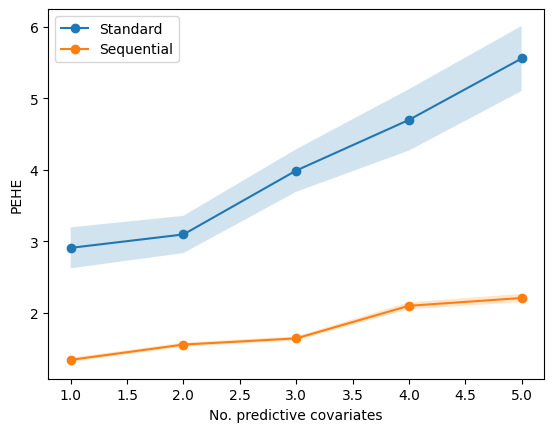

In [151]:

x = [1,2,3,4,5]
u_seq = pred_results[pred_results['method']=='seq_new'].groupby(['n_t']).mean()['u_pehe']
u_stand = pred_results[pred_results['method']=='standard'].groupby(['n_t']).mean()['u_pehe']

u_seq_std = pred_results[pred_results['method']=='seq_new'].groupby(['n_t']).std()['u_pehe'] / np.sqrt(10) * 1.96
u_stand_std = pred_results[pred_results['method']=='standard'].groupby(['n_t']).std()['u_pehe']/ np.sqrt(10) * 1.96


plt.plot(x, u_stand, 'o-', label = 'Standard')
plt.plot(x, u_seq, 'o-', label = 'Sequential')


plt.fill_between(x, u_stand - u_stand_std, u_stand + u_stand_std, alpha=0.2)
plt.fill_between(x, u_seq - u_seq_std, u_seq + u_seq_std, alpha=0.2)
plt.legend()
plt.xlabel('No. predictive covariates')
plt.ylabel('PEHE')
plt.savefig('plots/CATE_complexity_plot.png')

## Showing our metrics work

### D

In [121]:
def generate_propensities_datasets(n, correct):
    d = pd.DataFrame(np.random.normal(loc = 0, size=(n,20)))
    d['w'] = 0
    d.loc[:round(n/2),'w'] = 1
    d['y'] = np.random.normal(loc = 0, size=(n,1))
    d = d.sample(frac=1)

    n_correct = round(correct*n)
    d_adv = pd.DataFrame(np.random.normal(loc = 0, size=(n,20)))
    d_adv['w'] = 0
    d_adv.loc[:n_correct,'w'] = 1
    d_adv['y'] = np.random.normal(loc = 0, size=(n,1))
    d_adv = d_adv.sample(frac=1)

    return d, d_adv

In [122]:
def new_metrics_propensity_exp(n, corrects, n_iter):
    results = pd.DataFrame(columns=['treated %', 'f', 'd', 'beta', 'kl'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for c in corrects:
        for _ in range(n_iter):
            d_real, d_adv = generate_propensities_datasets(n, c)
            #f = evaluate_f(d_real,d_adv,'w','y')
            d = evaluate_d(d_real,d_adv,'w','y')
            #prec = alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_coverage_beta_OC']
            #inv_kl = kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['marginal']
            results.loc[len(results)] = [c, 0, d, 0, 0]
            print('done')
    return results


In [126]:
results_prop = new_metrics_propensity_exp(2000, [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], 10)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [127]:
results_prop.groupby('treated %').count()

,f,d,beta,kl
treated %,,,,
0.01,10,10,10,10
0.10,10,10,10,10
0.20,10,10,10,10
0.30,10,10,10,10
0.40,10,10,10,10
0.50,10,10,10,10
0.60,10,10,10,10
0.70,10,10,10,10
0.80,10,10,10,10


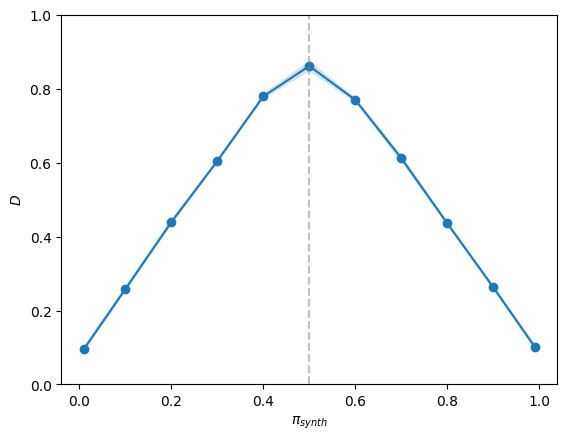

In [129]:
x = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
d = results_prop.groupby('treated %').mean()['d']
beta = results_prop.groupby('treated %').mean()['beta']
kl = results_prop.groupby('treated %').mean()['kl']
d_std = results_prop.groupby('treated %').std()['d'] / np.sqrt(10) * 1.96
beta_std = results_prop.groupby('treated %').std()['beta']/ np.sqrt(10) * 1.96
kl_std = results_prop.groupby('treated %').std()['kl']/ np.sqrt(10) * 1.96

plt.plot(x, d, 'o-', label = 'd')
#plt.plot(x, beta, label = 'beta')
#plt.plot(x, kl, label = 'kl')

plt.fill_between(x, d - d_std, d + d_std, alpha=0.2)
#plt.fill_between(x, beta - beta_std, beta + beta_std, alpha=0.2)
#plt.fill_between(x, kl - kl_std, kl + kl_std, alpha=0.2)
#plt.legend()
plt.ylim([0,1])
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('$D$')
plt.xlabel('$\pi_{synth}$')
plt.savefig('plots/propensity_metric_plot.png')

### U

In [22]:
def create_simulated_datasets(n, d, n_o, n_t, n_known, error_sd=0):
    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t, error_sd=error_sd)
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])

    d_real = pd.concat([X_df,w_df,y_df], axis=1)
    d_synth = pd.concat([X_df,w_df], axis=1)

    mu0_coefs = np.ones(n_o)
    mu0 = np.dot(X[:, : n_o] ** 2, mu0_coefs)

    mu1_coefs = np.ones(n_known)
    X_sel = X[:, n_o : n_o + n_known]
    mu1 = mu0 + np.dot(X_sel**2, mu1_coefs)

    new_column_values = []
    for index, value in d_synth['w'].iteritems():
        if value == 0:
            new_column_values.append(mu0[index])
        else:
            new_column_values.append(mu1[index])

    d_synth['y'] = new_column_values

    return d_real, d_synth

In [23]:
def run_utility_exp(n, d, n_o, n_t, n_knowns, n_iter, error_sd=0):
    results = pd.DataFrame(columns=['n_known', 'u_pehe', 'u_policy'])
    for n_known in n_knowns:
        for _ in range(n_iter):
            d_real, d_synth = create_simulated_datasets(n, d,n_o, n_t, n_known)
            u_pehe = evaluate_u_pehe(d_real, d_synth, 'w', 'y', n_units=d)
            u_policy = evaluate_u_policy(d_real, d_synth, 'w', 'y', n_units=d)

            results.loc[len(results)] = [n_known, u_pehe, u_policy]
            print(f'done {n_known} {_}')

    return results

In [24]:
results = run_utility_exp(1000, 10, 5, 5, [0,1,2,3,4,5], n_iter = 5)

done 0 0
done 0 1
done 0 2
done 0 3
done 0 4
done 1 0
done 1 1
done 1 2
done 1 3
done 1 4
done 2 0
done 2 1
done 2 2
done 2 3
done 2 4
done 3 0
done 3 1
done 3 2
done 3 3
done 3 4
done 4 0
done 4 1
done 4 2
done 4 3
done 4 4
done 5 0
done 5 1
done 5 2
done 5 3
done 5 4


In [25]:
results.to_csv('utility_simulated_experiment.csv', index=False)

In [116]:
results = pd.read_csv('utility_simulated_experiment.csv')

In [118]:
results.groupby('n_known').count()

,u_pehe,u_policy
n_known,,
0.0,5,5
1.0,5,5
2.0,5,5
3.0,5,5
4.0,5,5
5.0,5,5


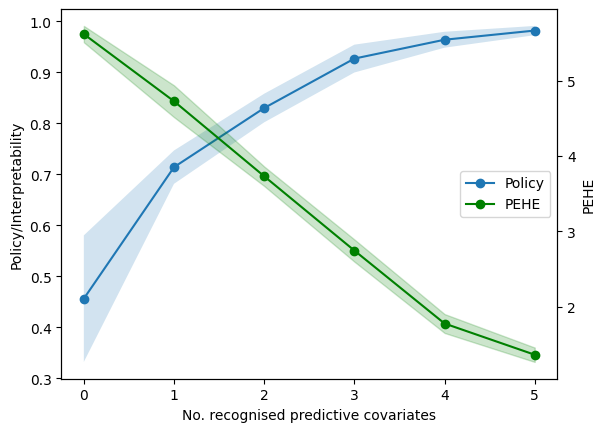

In [120]:
x = [0,1,2,3,4,5]
u_pehe = results.groupby('n_known').mean()['u_pehe']
u_policy = results.groupby('n_known').mean()['u_policy']
u_pehe_std = results.groupby('n_known').std()['u_pehe'] / np.sqrt(5) * 1.96
u_policy_std = results.groupby('n_known').std()['u_policy'] / np.sqrt(5) * 1.96

fig, ax1 = plt.subplots()
ax1.plot(x, u_policy, 'o-', label = 'Policy')
ax1.fill_between(x, u_policy - u_policy_std, u_policy + u_policy_std, alpha=0.2)
ax1.set_ylabel('Policy/Interpretability')

ax2 = ax1.twinx()
ax2.plot(x, u_pehe, 'o-', label = 'PEHE', color='g')
ax2.set_ylabel('PEHE')
ax2.fill_between(x, u_pehe - u_pehe_std, u_pehe + u_pehe_std, alpha=0.2, color='g')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1+handles2
labels=labels1+labels2

plt.legend(handles, labels, loc='center right')
ax1.set_xlabel('No. recognised predictive covariates')
plt.savefig('plots/utility_metric_plot.png')

([<matplotlib.lines.Line2D at 0x7f49a058ab90>,
 ['policy', 'int'])

## New covariate distribution illustrative test

In [34]:
def cov_dist_illustrative(n, n_covs):
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()
    mmd = MaximumMeanDiscrepancy()
    results = pd.DataFrame(columns=['n_cov', 'alpha', 'beta', 'kl', 'mmd'])
    for n_cov in n_covs:
        X, y, w, p, t = simulate_treatment_setup(n, n_cov)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])

        d_real = pd.concat([X_df,w_df,y_df], axis=1)
        d_syn = d_real.copy()
        c = d_real.drop(['w', 'y'], axis=1).columns
        d_syn[c] = 0
        results.loc[len(results)] = [n_cov, alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['delta_precision_alpha_OC'], 
                                     alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['delta_coverage_beta_OC'],
                                     kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['marginal'],
                                     mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['joint']]
    return results

In [41]:
results = cov_dist_illustrative(1000, [1,2,3,4,5,6,7,8,9,10])

In [42]:
results

,n_cov,alpha,beta,kl,mmd
0,1.0,0.896641,0.364267,0.685529,0.088571
1,2.0,0.823956,0.267933,0.527977,0.157971
2,3.0,0.749559,0.224000,0.433758,0.215335
3,4.0,0.678671,0.155133,0.370297,0.254347
4,5.0,0.736425,0.167400,0.325205,0.264557
5,6.0,0.529867,0.124067,0.291075,0.274397
6,7.0,0.629968,0.088333,0.264794,0.290047
7,8.0,0.725625,0.146133,0.244170,0.310178
8,9.0,0.699582,0.057600,0.226729,0.305175
9,10.0,0.314533,0.122867,0.212800,0.313197


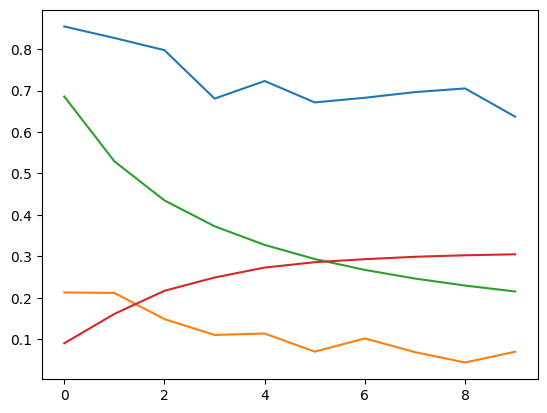

In [40]:
plt.plot(results['alpha'])
plt.plot(results['beta'])
plt.plot(results['kl'])
plt.plot(results['mmd'])

In [49]:
X, y, w, p, t = simulate_treatment_setup(1000, 2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
c = d_real.drop(['w', 'y'], axis=1).columns
#d_real[c] *= 10

In [50]:
d_syn = d_real.copy()
d_syn['w'] = 0

In [51]:
alpha = AlphaPrecision()
kl = InverseKLDivergence()
mmd = MaximumMeanDiscrepancy()

In [52]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.5455333333333334,
 'delta_coverage_beta_OC': 0.4749977011494253,
 'authenticity_OC': 0.416,
 'delta_precision_alpha_naive': 0.9398666666666667,
 'delta_coverage_beta_naive': 0.49839999999999995,
 'authenticity_naive': 0.503}

In [53]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.7693872037983206}

In [54]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.02762580954934199}

In [63]:
X, y, w, p, t = simulate_treatment_setup(1000, 2, n_t=2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
#d_real[c] *= 10

In [64]:
d_syn = pd.DataFrame(columns = d_real.columns)
d_syn[0] = d_real[0]
d_syn[1] = d_real[1]
d_syn['w'] = d_real['w']
d_syn['y'] = np.random.normal(loc = 0, size=(1000,1))

In [65]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.8506,
 'delta_coverage_beta_OC': 0.44566666666666654,
 'authenticity_OC': 0.604,
 'delta_precision_alpha_naive': 0.9993356321839081,
 'delta_coverage_beta_naive': 0.9993356321839081,
 'authenticity_naive': 0.0}

In [66]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.8239389674000923}

In [67]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.00893364031042121}

## OneClass Testing

In [122]:
OC_params  = {
    "rep_dim": 2, 
    "num_layers": 4, 
    "num_hidden": 32, 
    "activation": "ReLU",
    "dropout_prob": 0.2, 
    "dropout_active": False,
    "LossFn": "Weighted",
    "lr": 2e-3,
    "epochs": 1000,
    "warm_up_epochs" : 20,
    "train_prop" : 1.0,
    "weight_decay": 2e-3
}   

lambda_ = 0.1

OC_hyperparams = {
    "Radius": 1, 
    "nu": 1e-2
}

In [123]:
ihdp_cov = ihdp[['x1','x2','x3','x4','x5','x6']]
ihdp_cov_array = ihdp_cov.values.astype('float32')
ihdp_cov_tensor = torch.tensor(ihdp_cov_array, device='cuda')

In [171]:
d = np.random.normal(size=(1000,6)).astype('float32')
d_tensor = torch.tensor(d, device='cuda')

In [321]:
OC_params['input_dim'] = d.shape[1]
OC_params['reg_weights'] = torch.tensor([1/d.shape[1] for i in range(d.shape[1])], device='cuda')
OC_params['reg_weights'] = torch.tensor([100,0,0,0,0,0], device='cuda')
#OC_params['reg_weights'] = torch.tensor(np.repeat(10, 25), device='cuda')
OC_hyperparams['center'] = torch.ones(OC_params['rep_dim'])

In [322]:
model = OneClassLayer(params = OC_params, hyperparams=OC_hyperparams)

In [323]:
model.fit(d, verbosity=True)

epoch 0, loss 356.9244384765625
epoch 1, loss 351.957275390625
epoch 2, loss 347.19610595703125
epoch 3, loss 342.5008239746094
epoch 4, loss 337.72174072265625
epoch 5, loss 332.7275390625
epoch 6, loss 327.4333801269531
epoch 7, loss 321.76312255859375
epoch 8, loss 315.635498046875
epoch 9, loss 308.96771240234375
epoch 10, loss 301.677001953125
epoch 11, loss 293.67205810546875
epoch 12, loss 284.85101318359375
epoch 13, loss 275.110107421875
epoch 14, loss 264.3504943847656
epoch 15, loss 252.48809814453125
epoch 16, loss 239.48052978515625
epoch 17, loss 225.3479766845703
epoch 18, loss 210.2147216796875
epoch 19, loss 194.36085510253906
epoch 20, loss 178.29425048828125
epoch 21, loss 162.84600830078125
epoch 22, loss 149.27273559570312
epoch 23, loss 139.29913330078125
epoch 24, loss 134.81060791015625
epoch 25, loss 136.43252563476562
epoch 26, loss 141.40687561035156
epoch 27, loss 144.77247619628906
epoch 28, loss 143.59181213378906
epoch 29, loss 138.197998046875
epoch 30, 

epoch 54, loss 81.77720642089844
epoch 55, loss 80.25247192382812
epoch 56, loss 78.85094451904297
epoch 57, loss 77.60681915283203
epoch 58, loss 76.50650787353516
epoch 59, loss 75.50589752197266
epoch 60, loss 74.550048828125
epoch 61, loss 73.59078979492188
epoch 62, loss 72.59760284423828
epoch 63, loss 71.56189727783203
epoch 64, loss 70.49465942382812
epoch 65, loss 69.41956329345703
epoch 66, loss 68.36471557617188
epoch 67, loss 67.35466003417969
epoch 68, loss 66.40315246582031
epoch 69, loss 65.50933837890625
epoch 70, loss 64.65933227539062
epoch 71, loss 63.832115173339844
epoch 72, loss 63.00773239135742
epoch 73, loss 62.172637939453125
epoch 74, loss 61.324005126953125
epoch 75, loss 60.46889114379883
epoch 76, loss 59.62005615234375
epoch 77, loss 58.79069900512695
epoch 78, loss 57.9896354675293
epoch 79, loss 57.218849182128906
epoch 80, loss 56.4747314453125
epoch 81, loss 55.749351501464844
epoch 82, loss 55.034950256347656
epoch 83, loss 54.32604217529297
epoch 84

In [324]:
two_d = model(d_tensor)

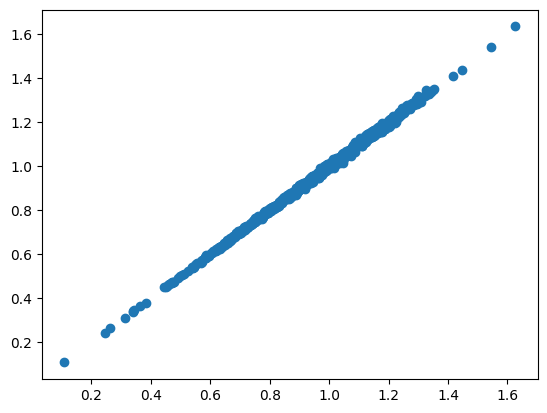

In [325]:
plt.scatter(two_d[:,0].cpu().detach().numpy(), two_d[:,1].cpu().detach().numpy())


In [326]:
p = [i for i in model.parameters()]

In [327]:
p[0][0]

tensor([ 0.0009,  0.2435,  0.4465, -0.3057,  0.2091, -0.2420], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [328]:
p[0][1]

tensor([ 0.0021, -0.3440,  0.3600, -0.2571, -0.0192,  0.3071], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [329]:
p[0][2]

tensor([-0.0008,  0.1214,  0.3498,  0.0333, -0.2970, -0.3349], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [330]:
true = np.repeat(0,6).astype('float32')
true_tensor = torch.tensor(true, device='cuda')

In [331]:
true_2d = model(true_tensor)

In [332]:
true_2d

tensor([0., 0.], device='cuda:0', grad_fn=<SqueezeBackward3>)

In [345]:
test = torch.tensor([1,0,0,0,0,0], device='cuda').float()

In [348]:
model(test)

tensor([0.0335, 0.0338], device='cuda:0', grad_fn=<SqueezeBackward3>)

In [294]:
# between 0.38 - 0.7 for no weighting

## Privacy

In [35]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.data =X
        self.labels = y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [58]:
delta_prescence = DeltaPresence()
domias = DomiasMIABNAF()
identifiability = IdentifiabilityScore()
k_anon = kAnonymization()
ldiversity = lDiversityDistinct()

In [ ]:
# do privacy on simulated datasets to make it easier/faster

In [153]:
def privacy_comparison(real, gen, treatment_col, outcome_col, delta, epsilons, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'epsilon', 'f', 'c', 'd', 'avg_u_pehe'])
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    for epsilon in epsilons:
        for _ in range(n_iter):
            synth = generate_standard(real, gen, private=True, epsilon=epsilon, delta=delta)

            results.loc[len(results)] = ['standard', epsilon, evaluate_f(real, synth, treatment_col, outcome_col), evaluate_c(real, synth, treatment_col, outcome_col), 
                                     evaluate_d(real, synth, treatment_col, outcome_col), evaluate_average_u_pehe(real, synth, treatment_col, outcome_col, n_units)]

            synth_seq = generate_sequentially(real, gen, treatment_col, outcome_col, private=True, epsilon = epsilon/3, delta=delta/3)

            results.loc[len(results)] = ['sequential', epsilon, evaluate_f(real, synth_seq, treatment_col, outcome_col), evaluate_c(real, synth_seq, treatment_col, outcome_col), 
                                     evaluate_d(real, synth_seq, treatment_col, outcome_col), evaluate_average_u_pehe(real, synth_seq, treatment_col, outcome_col, n_units)]
    
            if save:
                print('saving results')
                results.to_csv(fp, index=False)
    return results

In [235]:
X,y,w,p,t = simulate_treatment_setup(1000, d=5, n_t=3, n_c=2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])
d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [237]:
test = privacy_comparison(d_real, 'dpgan', 'w', 'y', delta = 1e-3, epsilons = [1.5], n_iter = 10, save=True, fp ='simulated_privacy_dpgan_more_runs.csv')

[2024-05-14T10:57:17.521831+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:57:17.523128+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:57:17.523486+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan model


 25%|██▍       | 499/2000 [00:46<02:21, 10.62it/s]


Generating dpgan synthetic dataset


[2024-05-14T10:59:13.255637+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:59:13.256644+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T10:59:13.257064+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:39<02:17, 11.29it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T11:01:13.973150+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:01:13.974006+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:01:13.974407+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 15%|█▍        | 299/2000 [00:28<02:42, 10.49it/s]


Generating dpgan synthetic dataset


[2024-05-14T11:02:54.124679+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:02:54.125972+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T11:02:54.126333+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 25%|██▍       | 499/2000 [00:43<02:11, 11.40it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])

In [256]:
jobs

,training,age,education,black,hispanic,married,no_degree,re75,re78
0,0.0,19.0,9.0,1.0,0.0,1.0,1.0,0.0000,16658.250
1,0.0,33.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.000
2,0.0,25.0,10.0,1.0,0.0,1.0,1.0,0.0000,0.000
3,1.0,48.0,4.0,1.0,0.0,0.0,1.0,0.0000,6551.592
4,0.0,54.0,11.0,1.0,0.0,0.0,1.0,0.0000,7812.522
...,...,...,...,...,...,...,...,...,...
717,1.0,45.0,5.0,1.0,0.0,1.0,1.0,0.0000,8546.715
718,1.0,19.0,10.0,1.0,0.0,0.0,1.0,385.2741,8124.715
719,1.0,26.0,12.0,1.0,0.0,1.0,0.0,5794.8310,1424.944
720,0.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000,11197.340


In [261]:
normalized=(jobs-jobs.mean())/jobs.std()

In [263]:
normalized_jobs = jobs.copy()
normalized_jobs['age'] = normalized['age']
normalized_jobs['education'] = normalized['education']
normalized_jobs['re75'] = normalized['re75']
normalized_jobs['re78'] = normalized['re78']

In [284]:
test_2 = privacy_comparison(normalized_jobs, 'dpgan', 'training', 're78', delta = 1e-3, epsilons = [50], n_iter = 10, save=True, fp ='jobs_privacy_dpgan_normalized_100.csv')

[2024-05-14T23:34:22.891253+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:34:22.892272+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:34:22.892762+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan model


 15%|█▍        | 299/2000 [00:25<02:26, 11.58it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:35:55.788155+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:35:55.789541+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:35:55.790034+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 32%|███▏      | 649/2000 [00:51<01:47, 12.61it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:37:59.540645+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:37:59.541360+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:37:59.541779+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 20%|█▉        | 399/2000 [00:35<02:21, 11.34it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:39:29.660220+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:39:29.661585+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:39:29.661945+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 25%|██▍       | 499/2000 [00:39<01:57, 12.76it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:41:24.388742+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:41:24.389334+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:41:24.389711+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 37%|███▋      | 749/2000 [01:05<01:49, 11.39it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:43:19.649674+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:43:19.650701+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:43:19.651093+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:35<02:01, 12.77it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:45:08.678693+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:45:08.679493+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:45:08.679919+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 25%|██▍       | 499/2000 [00:43<02:09, 11.60it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:47:00.029130+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:47:00.030127+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:47:00.030459+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 27%|██▋       | 549/2000 [00:43<01:54, 12.71it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:48:55.452475+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:48:55.453218+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:48:55.453604+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:29<02:21, 11.66it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:50:17.383815+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:50:17.384885+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:50:17.385216+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:35<02:01, 12.72it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:52:06.251715+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:52:06.252466+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:52:06.252860+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:30<02:22, 11.58it/s]


Generating dpgan synthetic dataset


[2024-05-14T23:53:30.443031+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:53:30.444040+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:53:30.444502+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 20%|█▉        | 399/2000 [00:31<02:08, 12.47it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T23:55:14.173042+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:55:14.173807+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T23:55:14.174400+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 25%|██▍       | 499/2000 [00:43<02:10, 11.54it/s]


Generating dpgan synthetic dataset


Bad pipe message: %s [b'"_k\xa4\x15\x0e\x1f\x07l\xf8\xe2\xf2\xcc\xbfd\x91\xdfb hW\xe0\xc2\xbd\xf4\x9f8\x13W\xf2\xc7\xca\'\xd1\xb2MZ\x9a\x84\xb7\xa8I\x18t\x98\x1d\xf6^\x9d\x0cs\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02', b'\x00-']
Bad pipe message: %s [b'\xc6\xd0q9\x15']
Bad pipe message: %s [b"k\xf69\xf4\x1f\x93\x08\x83~\x87!\xd4B\xb5\xdc\x9cz'\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e", b"\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\

Fitting dpgan covariate model


  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([1]) and output[0] has a shape of torch.Size([]).

In [277]:
test = privacy_comparison(normalized_jobs, 'dpgan', 'training', 're78', delta = 1e-3, epsilons = [15,20], n_iter = 10, save=True, fp ='jobs_privacy_dpgan_normalized_2.csv')

[2024-05-14T12:21:31.114264+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:21:31.115572+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:21:31.116002+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan model


 25%|██▍       | 499/2000 [00:40<02:00, 12.46it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:22:42.613998+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:22:42.615367+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:22:42.615738+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 25%|██▍       | 499/2000 [00:38<01:54, 13.07it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:24:09.461483+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:24:09.462354+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:24:09.462834+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 35%|███▍      | 699/2000 [00:56<01:44, 12.39it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:25:43.682863+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:25:43.684107+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:25:43.684500+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:26<02:05, 13.16it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:26:59.364283+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:26:59.365035+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:26:59.365446+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 32%|███▏      | 649/2000 [00:51<01:47, 12.52it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:28:40.174611+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:28:40.175623+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:28:40.176110+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:27<02:10, 12.64it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:29:56.430598+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:29:56.431381+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:29:56.431772+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:28<02:12, 12.46it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:30:59.898808+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:30:59.900002+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:30:59.900398+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 20%|█▉        | 399/2000 [00:30<02:03, 12.99it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:32:22.676669+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:32:22.677521+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:32:22.677956+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 15%|█▍        | 299/2000 [00:24<02:17, 12.37it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:33:18.518686+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:33:18.519706+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:33:18.520047+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 20%|█▉        | 399/2000 [00:30<02:03, 12.98it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:34:38.540197+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:34:38.540938+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:34:38.541313+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 25%|██▍       | 499/2000 [00:40<02:01, 12.35it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:36:04.645233+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:36:04.646621+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:36:04.647403+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 27%|██▋       | 549/2000 [00:42<01:51, 12.99it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:37:33.616348+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:37:33.617215+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:37:33.617709+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 20%|█▉        | 399/2000 [00:32<02:08, 12.46it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:38:42.061274+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:38:42.062646+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:38:42.063170+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 27%|██▋       | 549/2000 [00:43<01:55, 12.61it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:40:12.954854+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:40:12.955472+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:40:12.955901+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:27<02:12, 12.48it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:41:27.543826+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:41:27.544853+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:41:27.545215+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:26<02:07, 12.97it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:42:44.090210+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:42:44.090770+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:42:44.091138+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 45%|████▍     | 899/2000 [01:12<01:28, 12.42it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:44:43.937966+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:44:43.938631+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:44:43.938975+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 22%|██▏       | 449/2000 [00:34<01:59, 13.01it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:46:06.587769+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:46:06.588348+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:46:06.588724+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 30%|██▉       | 599/2000 [00:47<01:52, 12.49it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:47:26.924360+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:47:26.925030+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:47:26.925386+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:26<02:07, 13.00it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:48:42.733540+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:48:42.734466+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:48:42.734930+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 20%|█▉        | 399/2000 [00:32<02:08, 12.42it/s]


Generating dpgan synthetic dataset


[2024-05-14T12:49:52.279155+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:49:52.280389+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:49:52.281034+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting dpgan covariate model


 17%|█▋        | 349/2000 [00:27<02:08, 12.88it/s]


Generating dpgan synthetic covariates
Fitting propensity model
Generating propensities
Fitting private CATE learner
Generating POs


[2024-05-14T12:51:11.976489+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:51:11.977424+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-14T12:51:11.977946+0000][130783][CRITICAL] module plugin_goggle load failed


saving results
Fitting dpgan model


 17%|█▋        | 349/2000 [00:28<02:16, 12.08it/s]


Generating dpgan synthetic dataset


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])

In [239]:
test = pd.read_csv('simulated_privacy_dpgan_more_runs.csv')

In [240]:
test

,method,epsilon,f,c,d,avg_u_pehe
0,standard,1.5,0.772533,0.206000,0.455955,4.700255
1,sequential,1.5,0.375800,0.433667,0.415196,3.590751


In [285]:
#results_comb = pd.read_csv('simulated_privacy_dpgan_combined.csv')
results_comb = pd.read_csv('jobs_privacy_dpgan_normalized.csv')

In [290]:
test = pd.read_csv('jobs_privacy_dpgan_normalized_100.csv')

In [291]:
results_comb = pd.concat([results_comb, test])

In [234]:
#results_comb.to_csv('simulated_privacy_dpgan_combined.csv', index=False)

In [310]:
results_comb = results_comb.reset_index(drop=True)

In [313]:
results_comb = results_comb.drop([60,61,62,63])

In [314]:
results_comb.groupby('epsilon').count()

,method,f,c,d,avg_u_pehe
epsilon,,,,,
5,20,20,20,20,20
10,20,20,20,20,20
15,20,20,20,20,20
50,12,12,12,12,12


In [320]:
results_standard = results_comb[results_comb['method']=='standard']

In [321]:
results_seq = results_comb[results_comb['method']=='sequential']

In [322]:
x = [5,10,15,50]
d_stand = results_standard.groupby('epsilon').mean()['d']
d_seq = results_seq.groupby('epsilon').mean()['d']
f_stand = results_standard.groupby('epsilon').mean()['f']
f_seq = results_seq.groupby('epsilon').mean()['f']
c_stand = results_standard.groupby('epsilon').mean()['c']
c_seq = results_seq.groupby('epsilon').mean()['c']
u_stand = results_standard.groupby('epsilon').mean()['avg_u_pehe']
u_seq = results_seq.groupby('epsilon').mean()['avg_u_pehe']


d_stand_std = results_standard.groupby('epsilon').std()['d'] / np.sqrt(10) * 1.96
d_seq_std = results_seq.groupby('epsilon').std()['d']/ np.sqrt(10)* 1.96
f_stand_std = results_standard.groupby('epsilon').std()['f']/ np.sqrt(10)* 1.96
f_seq_std = results_seq.groupby('epsilon').std()['f']/ np.sqrt(10)* 1.96
c_stand_std = results_standard.groupby('epsilon').std()['c']/ np.sqrt(10)* 1.96
c_seq_std = results_seq.groupby('epsilon').std()['c']/ np.sqrt(10)* 1.96
u_stand_std = results_standard.groupby('epsilon').std()['avg_u_pehe']/ np.sqrt(10)* 1.96
u_seq_std = results_seq.groupby('epsilon').std()['avg_u_pehe']/ np.sqrt(10)* 1.96

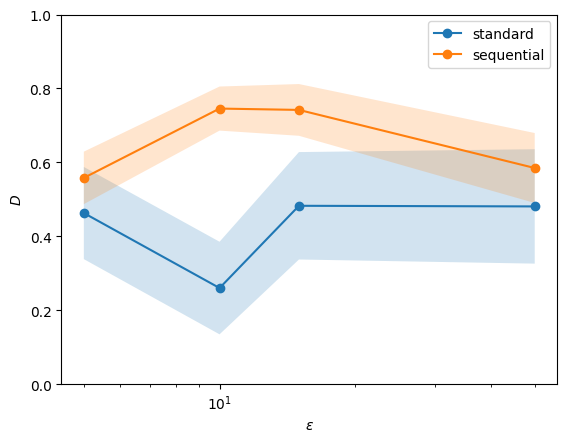

In [323]:
plt.plot(x, d_stand, 'o-', label = 'standard')
plt.plot(x, d_seq, 'o-', label = 'sequential')
plt.fill_between(x, d_stand - d_stand_std, d_stand + d_stand_std, alpha=0.2)
plt.fill_between(x, d_seq - d_seq_std, d_seq + d_seq_std, alpha=0.2)
plt.legend()
plt.ylim([0,1])
plt.ylabel('$D$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
#plt.savefig('plots/D_with_epsilon.png')

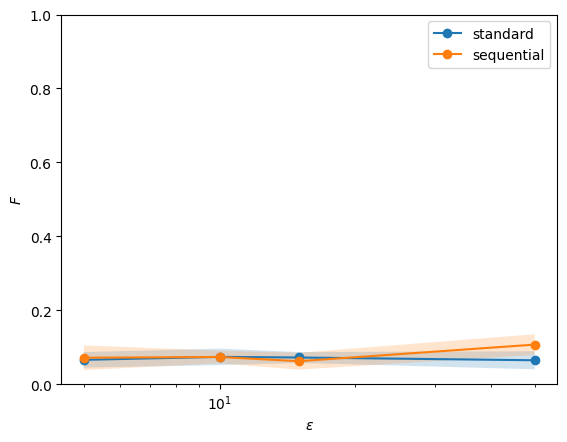

In [324]:
plt.plot(x, f_stand, 'o-', label = 'standard')
plt.plot(x, f_seq, 'o-', label = 'sequential')
plt.fill_between(x, f_stand - f_stand_std, f_stand + f_stand_std, alpha=0.2)
plt.fill_between(x, f_seq - f_seq_std, f_seq + f_seq_std, alpha=0.2)
plt.legend()
plt.ylim([0,1])
plt.ylabel('$F$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
#plt.savefig('plots/F_with_epsilon.png')

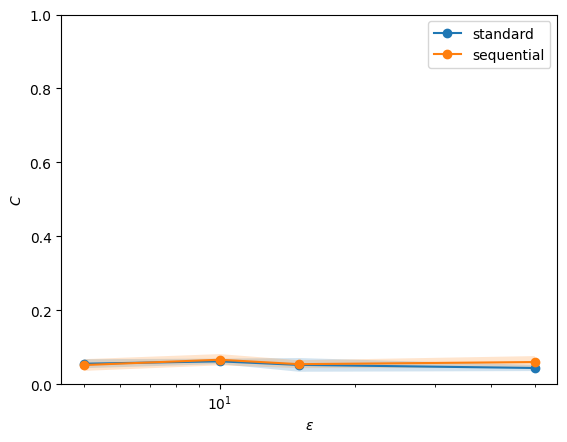

In [325]:
plt.plot(x, c_stand, 'o-', label = 'standard')
plt.plot(x, c_seq, 'o-', label = 'sequential')
plt.fill_between(x, c_stand - c_stand_std, c_stand + c_stand_std, alpha=0.2)
plt.fill_between(x, c_seq - c_seq_std, c_seq + c_seq_std, alpha=0.2)
plt.legend()
plt.ylim([0,1])
plt.ylabel('$C$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
#plt.savefig('plots/C_with_epsilon.png')

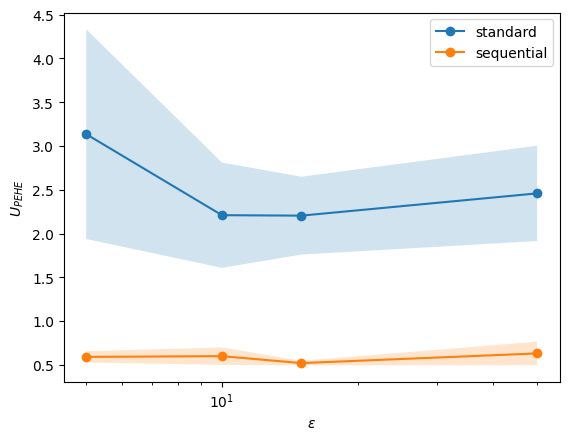

In [326]:
plt.plot(x, u_stand, 'o-', label = 'standard')
plt.plot(x, u_seq, 'o-', label = 'sequential')
plt.fill_between(x, u_stand - u_stand_std, u_stand + u_stand_std, alpha=0.2)
plt.fill_between(x, u_seq - u_seq_std, u_seq + u_seq_std, alpha=0.2)
plt.legend()
plt.ylabel('$U_{PEHE}$')
plt.xlabel('$\epsilon$')
plt.xscale('log')
#plt.savefig('plots/U_with_epsilon.png')

In [78]:
X_train, X_test, w_train, w_test = train_test_split(X, w, test_size=0.2)

In [91]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # Input size 5, output size 64
        self.fc2 = nn.Linear(64, 32)  # Input size 64, output size 32
        self.fc3 = nn.Linear(32, 1)   # Input size 32, output size 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataset = CustomDataset(X_train, w_train)
data_loader = DataLoader(dataset, batch_size = 19)
privacy_engine = PrivacyEngine()

model_dp, optimizer_dp, data_loader_dp = privacy_engine.make_private_with_epsilon(
    module = model,
    optimizer = optimizer,
    data_loader = data_loader,
    target_epsilon = 10,
    target_delta = 1e-5,
    max_grad_norm = 1.2,
    epochs = 50
)

num_epochs = 50
for epoch in range(num_epochs):

    for _batch_idx, (data, target) in enumerate(tqdm(data_loader_dp, disable=True)):
    # Forward pass
        outputs = model_dp(data)
        loss = criterion(outputs.squeeze(), target)

        # Backward pass and optimization
        optimizer_dp.zero_grad()
        loss.backward()
        optimizer_dp.step()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.6841
Epoch [2/50], Loss: 0.6441
Epoch [3/50], Loss: 0.6528
Epoch [4/50], Loss: 0.6603
Epoch [5/50], Loss: 0.6216
Epoch [6/50], Loss: 0.6272
Epoch [7/50], Loss: 0.5847
Epoch [8/50], Loss: 0.7443
Epoch [9/50], Loss: 0.7501
Epoch [10/50], Loss: 0.6599
Epoch [11/50], Loss: 0.7409
Epoch [12/50], Loss: 0.4967
Epoch [13/50], Loss: 0.9737
Epoch [14/50], Loss: 0.6863
Epoch [15/50], Loss: 0.6974
Epoch [16/50], Loss: 0.5449
Epoch [17/50], Loss: 0.7667
Epoch [18/50], Loss: 0.9656
Epoch [19/50], Loss: 0.6077
Epoch [20/50], Loss: 0.7115
Epoch [21/50], Loss: 0.9635
Epoch [22/50], Loss: 0.8643
Epoch [23/50], Loss: 0.4925
Epoch [24/50], Loss: 0.7174
Epoch [25/50], Loss: 1.0144
Epoch [26/50], Loss: 0.4937
Epoch [27/50], Loss: 0.6809
Epoch [28/50], Loss: 0.8765
Epoch [29/50], Loss: 0.6899
Epoch [30/50], Loss: 0.6311
Epoch [31/50], Loss: 0.8791
Epoch [32/50], Loss: 0.6959
Epoch [33/50], Loss: 0.5583
Epoch [34/50], Loss: 0.6392
Epoch [35/50], Loss: 0.8068
Epoch [36/50], Loss: 0.4784
E

In [119]:
clf = RandomForestClassifier()
clf_dp = LogisticRegressionDP(epsilon=500)

In [112]:
with torch.no_grad():
    outputs = model(torch.tensor(X_test).float())
    pred_nn = torch.round(outputs).squeeze()

In [120]:
clf.fit(X_train, w_train)

RandomForestClassifier()

In [121]:
clf_dp.fit(X_train, w_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.6666666666666667, 0), (1.6666666666666667, 0), (0.3333333333333333, 0), (0.6666666666666666, 0), (1.0, 0), ...]),
                   data_norm=4.727320492026039, epsilon=500)

In [122]:
w_pred = clf.predict(X_test)
accuracy_score(w_test, w_pred)

0.545

In [123]:
sklearn.metrics.f1_score(w_test, w_pred)

0.6761565836298933

In [124]:
w_pred_dp = clf_dp.predict(X_test)
accuracy_score(w_test, w_pred_dp)

0.595

In [125]:
accuracy_score(w_test, pred_nn)

0.59

## Model selection with old/new metrics

In [164]:
def metric_selection_exp(real, gens, treatment_col, outcome_col, n_iter, cate, save=False, fp=''):
    results = pd.DataFrame(columns=['gen', 'naive_f', 'naive_c', 'f', 'c', 'd', 'avg_u_pehe', 'true_pehe'])
    alpha = AlphaPrecision()
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    for gen in gens:
        for _ in range(n_iter):
            synth = generate_standard(real, gen)

            l = SLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
            y = np.array(synth[outcome_col])
            w = np.array(synth[treatment_col])
            l.fit(X, y, w)
            pred = l.predict(X_real)

            true_mse = mean_squared_error(cate, pred.detach().cpu().numpy(), squared=False)
            


            results.loc[len(results)] = [gen, alpha.evaluate(GenericDataLoader(real), GenericDataLoader(synth))['delta_precision_alpha_OC'], 
                                        alpha.evaluate(GenericDataLoader(real), GenericDataLoader(synth))['delta_coverage_beta_OC'], 
                                        evaluate_f(real, synth, treatment_col, outcome_col), evaluate_c(real, synth, treatment_col, outcome_col), 
                                        evaluate_d(real, synth, treatment_col, outcome_col), evaluate_average_u_pehe(real, synth, treatment_col, outcome_col, n_units), true_mse]

    if save:
        results.to_csv(fp, index=False)
    
    return results

In [175]:
X,y,w,p,t = simulate_treatment_setup(1000, d=10, n_c=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])
d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [176]:
r = metric_selection_exp(d_real, ['ddpm', 'tvae', 'ctgan'], 'w','y',5, t)

[2024-05-13T03:29:01.651510+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:29:01.652506+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:29:01.652932+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.94it/s, loss=0.94]


Generating ddpm synthetic dataset


[2024-05-13T03:31:34.028551+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:31:34.029626+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:31:34.029980+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s, loss=0.928]


Generating ddpm synthetic dataset


[2024-05-13T03:33:55.126337+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:33:55.127741+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:33:55.128205+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.96it/s, loss=0.927]


Generating ddpm synthetic dataset


[2024-05-13T03:36:14.336208+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:36:14.337662+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:36:14.338061+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.71it/s, loss=0.938]


Generating ddpm synthetic dataset


[2024-05-13T03:38:36.470122+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:38:36.471614+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:38:36.472100+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ddpm model


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.82it/s, loss=0.928]


Generating ddpm synthetic dataset


[2024-05-13T03:41:07.441739+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:41:07.443254+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:41:07.443683+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 50%|█████     | 500/1000 [00:30<00:30, 16.35it/s]


Generating tvae synthetic dataset


[2024-05-13T03:43:15.939077+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:43:15.940143+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:43:15.940485+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 50%|█████     | 500/1000 [00:32<00:32, 15.51it/s]


Generating tvae synthetic dataset


[2024-05-13T03:45:30.475380+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:45:30.476786+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:45:30.477166+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 45%|████▌     | 450/1000 [00:29<00:36, 15.25it/s]


Generating tvae synthetic dataset


[2024-05-13T03:47:39.991895+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:47:39.992968+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:47:39.993286+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 40%|████      | 400/1000 [00:20<00:31, 19.07it/s]


Generating tvae synthetic dataset


[2024-05-13T03:49:37.466964+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:49:37.468441+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:49:37.468936+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting tvae model


 50%|█████     | 500/1000 [00:30<00:30, 16.38it/s]


Generating tvae synthetic dataset


[2024-05-13T03:51:51.257741+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:51:51.259304+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:51:51.259740+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 40%|███▉      | 799/2000 [01:14<01:51, 10.75it/s]


Generating ctgan synthetic dataset


[2024-05-13T03:54:50.357566+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:54:50.359033+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:54:50.359489+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 20%|█▉        | 399/2000 [00:31<02:07, 12.58it/s]


Generating ctgan synthetic dataset


[2024-05-13T03:57:14.446486+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:57:14.448338+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T03:57:14.448779+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 60%|█████▉    | 1199/2000 [01:37<01:05, 12.31it/s]


Generating ctgan synthetic dataset


[2024-05-13T04:00:38.856632+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T04:00:38.857719+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T04:00:38.858068+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 32%|███▏      | 649/2000 [00:53<01:51, 12.15it/s]


Generating ctgan synthetic dataset


[2024-05-13T04:03:17.469196+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T04:03:17.470684+0000][3915287][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-13T04:03:17.471267+0000][3915287][CRITICAL] module plugin_goggle load failed


Fitting ctgan model


 42%|████▏     | 849/2000 [01:07<01:31, 12.64it/s]


Generating ctgan synthetic dataset


In [177]:
r.groupby('gen').mean()

,naive_f,naive_c,f,c,d,avg_u_pehe,true_pehe
gen,,,,,,,
ctgan,0.220667,0.213880,0.712213,0.429227,0.828299,4.130368,3.345431
ddpm,0.169760,0.149907,0.372320,0.317427,0.843055,5.022178,6.463229
tvae,0.194000,0.267880,0.417520,0.412493,0.850976,4.636204,4.382946


In [181]:
r

,gen,naive_f,naive_c,f,c,d,avg_u_pehe,true_pehe
0,ddpm,0.159200,0.161000,0.347800,0.315200,0.827596,5.019045,6.180081
1,ddpm,0.193267,0.162933,0.438533,0.348800,0.872552,4.872704,6.107316
2,ddpm,0.187933,0.181000,0.376067,0.315867,0.840065,4.847493,4.411336
3,ddpm,0.156400,0.108333,0.358467,0.312400,0.810350,5.646578,10.316340
4,ddpm,0.152000,0.136267,0.340733,0.294867,0.864712,4.725068,5.301073
5,tvae,0.197533,0.278000,0.391933,0.397467,0.859963,4.561422,4.646987
6,tvae,0.212333,0.275533,0.611667,0.456133,0.792024,5.628002,4.371593
7,tvae,0.201133,0.243533,0.353267,0.401733,0.879268,4.266879,4.128672
8,tvae,0.150867,0.261067,0.264600,0.354400,0.852342,4.254686,4.494903
9,tvae,0.208133,0.281267,0.466133,0.452733,0.871281,4.470029,4.272577


In [180]:
r.groupby('gen').std()

,naive_f,naive_c,f,c,d,avg_u_pehe,true_pehe
gen,,,,,,,
ctgan,0.014336,0.042557,0.011009,0.031624,0.054128,0.347790,0.071587
ddpm,0.019289,0.028169,0.039335,0.019531,0.025771,0.364355,2.270142
tvae,0.024798,0.015647,0.130599,0.042544,0.034535,0.569830,0.199511


In [178]:
r.groupby('gen').mean().corr()

,naive_f,naive_c,f,c,d,avg_u_pehe,true_pehe
naive_f,1.000000,0.518293,0.931116,0.916356,-0.661953,-0.998754,-0.976275
naive_c,0.518293,1.000000,0.170679,0.817334,0.297928,-0.474967,-0.691179
f,0.931116,0.170679,1.000000,0.707212,-0.889731,-0.948158,-0.830049
c,0.916356,0.817334,0.707212,1.000000,-0.306493,-0.895233,-0.981308
d,-0.661953,0.297928,-0.889731,-0.306493,1.000000,0.698535,0.483944
avg_u_pehe,-0.998754,-0.474967,-0.948158,-0.895233,0.698535,1.000000,0.964251
true_pehe,-0.976275,-0.691179,-0.830049,-0.981308,0.483944,0.964251,1.000000


In [182]:
r.corr()

,naive_f,naive_c,f,c,d,avg_u_pehe,true_pehe
naive_f,1.000000,0.439887,0.835680,0.822514,-0.196454,-0.425639,-0.666643
naive_c,0.439887,1.000000,0.179318,0.758916,0.294362,-0.381417,-0.587392
f,0.835680,0.179318,1.000000,0.715389,-0.333082,-0.384802,-0.569777
c,0.822514,0.758916,0.715389,1.000000,0.046189,-0.437312,-0.634235
d,-0.196454,0.294362,-0.333082,0.046189,1.000000,-0.413797,-0.062527
avg_u_pehe,-0.425639,-0.381417,-0.384802,-0.437312,-0.413797,1.000000,0.711669
true_pehe,-0.666643,-0.587392,-0.569777,-0.634235,-0.062527,0.711669,1.000000


In [282]:
def propensity_failure_selection_exp(n, d, n_c, n_t, n_iter):
    results = pd.DataFrame(columns = ['dataset', 'naive_f', 'naive_c', 'f', 'c', 'd', 'u_pehe', 'oracle_pehe'])
    alpha = AlphaPrecision()
    for i in range(n_iter):
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t, seed = i)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        X_adv,y_adv,_,_,_ = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t, seed=i+100)
        X_adv_df = pd.DataFrame(X_adv)
        y_adv_df = pd.DataFrame(y_adv, columns = ['y'])
        w_adv = np.random.choice(2, n, p=[0.9,0.1])
        w_adv_df = pd.DataFrame(w_adv, columns = ['w'])
        d_adv = pd.concat([X_adv_df,w_adv_df,y_adv_df], axis=1)

        l_adv = SLearner(n_unit_in=d, binary_y=False, seed=random.randint(0,1000000))
        l_adv.fit(X_adv, y_adv, w_adv)
        pred_adv = l_adv.predict(X)
        adv_oracle_pehe = mean_squared_error(t, pred_adv.detach().cpu().numpy(), squared=False)

        X_test,y_test,w_test,_,_ = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t, seed=i+200)
        X_test_df = pd.DataFrame(X_test)
        y_test_df = pd.DataFrame(y_test, columns = ['y'])
        w_test_df = pd.DataFrame(w_test, columns = ['w'])
        d_test = pd.concat([X_test_df,w_test_df,y_test_df], axis=1)

        l_test = SLearner(n_unit_in=d, binary_y=False, seed=random.randint(0,1000000))
        l_test.fit(X_test, y_test, w_test)
        pred_test = l_test.predict(X)
        test_oracle_pehe = mean_squared_error(t, pred_test.detach().cpu().numpy(), squared=False)

        results.loc[len(results)] = ['adv', alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_precision_alpha_OC'], 
            alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_coverage_beta_OC'], 
            evaluate_f(d_real, d_adv, 'w', 'y'), evaluate_c(d_real, d_adv, 'w', 'y'), 
            evaluate_d(d_real, d_adv, 'w', 'y'), evaluate_average_u_pehe(d_real, d_adv, 'w', 'y', d), adv_oracle_pehe]

        results.loc[len(results)] = ['good', alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_test))['delta_precision_alpha_OC'], 
            alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_test))['delta_coverage_beta_OC'], 
            evaluate_f(d_real, d_test, 'w', 'y'), evaluate_c(d_real, d_test, 'w', 'y'), 
            evaluate_d(d_real, d_test, 'w', 'y'), evaluate_average_u_pehe(d_real, d_test, 'w', 'y', d), test_oracle_pehe]

    return results
        

In [285]:
results = propensity_failure_selection_exp(1000, 20, 15, 5, 5)

In [287]:
results.groupby('dataset').mean()

,naive_f,naive_c,f,c,d,u_pehe,oracle_pehe
dataset,,,,,,,
adv,0.249667,0.250533,0.504933,0.333000,0.171312,9.512197,5.934949
good,0.325773,0.230040,0.516107,0.321747,0.825531,4.045274,3.015091


In [288]:
results.groupby('dataset').std()

,naive_f,naive_c,f,c,d,u_pehe,oracle_pehe
dataset,,,,,,,
adv,0.046114,0.030448,0.085821,0.036566,0.025064,0.858537,0.462084
good,0.050865,0.023497,0.094260,0.048294,0.024362,0.166573,0.093107


In [289]:
results.to_csv('model_selection_propensity_failure.csv', index=False)

In [697]:
def model_selection_exp(n, d, n_c, n_t, n_iter):
    results = pd.DataFrame(columns = ['method', 'alpha', 'beta', 'f', 'c', 'd', 'u_pehe', 'oracle_pehe'])
    alpha = AlphaPrecision()

    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t)
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])
    d_real = pd.concat([X_df,w_df,y_df], axis=1)

    for _ in range(n_iter):
    
        d_standard = generate_standard_test(d_real, 'arf')
        X_stand = np.array(d_standard.drop(['w', 'y'], axis=1))
        y_stand = np.array(d_standard['y'])
        w_stand = np.array(d_standard['w'])

        l_stand = SLearner(n_unit_in=d, binary_y=False, seed=random.randint(0,1000000))
        l_stand.fit(X_stand, y_stand, w_stand)
        pred_stand = l_stand.predict(X)
        oracle_standard = mean_squared_error(t, pred_stand.detach().cpu().numpy(), squared=False)

        d_seq = generate_sequentially_test(d_real, 'arf', 'w', 'y')
        X_seq = np.array(d_seq.drop(['w', 'y'], axis=1))
        y_seq = np.array(d_seq['y'])
        w_seq = np.array(d_seq['w'])

        l_seq = SLearner(n_unit_in=d, binary_y=False, seed=random.randint(0,1000000))
        l_seq.fit(X_seq, y_seq, w_seq)
        pred_seq = l_seq.predict(X)
        oracle_seq = mean_squared_error(t, pred_seq.detach().cpu().numpy(), squared=False)

        results.loc[len(results)] = ['standard', alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_standard))['delta_precision_alpha_OC'], 
            alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_standard))['delta_coverage_beta_OC'], 
            evaluate_f(d_real, d_standard, 'w', 'y'), evaluate_c(d_real, d_standard, 'w', 'y'), 
            evaluate_d(d_real, d_standard, 'w', 'y'), evaluate_average_u_pehe(d_real, d_standard, 'w', 'y', d), oracle_standard]

        results.loc[len(results)] = ['seq', alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_seq))['delta_precision_alpha_OC'], 
            alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_seq))['delta_coverage_beta_OC'], 
            evaluate_f(d_real, d_seq, 'w', 'y'), evaluate_c(d_real, d_seq, 'w', 'y'), 
            evaluate_d(d_real, d_seq, 'w', 'y'), evaluate_average_u_pehe(d_real, d_seq, 'w', 'y', d), oracle_seq]

    return results

In [698]:
model_selection_results = model_selection_exp(1000, 40, 0, 10, 5)

[2024-05-15T04:49:05.658062+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:05.661529+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:05.662011+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.474
Generating arf synthetic dataset


[2024-05-15T04:49:14.726832+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:14.727913+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:49:14.728298+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4425
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T04:51:51.066177+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:51.067666+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:51.068189+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.4845
Generating arf synthetic dataset


[2024-05-15T04:51:59.868621+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:59.869429+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:51:59.869789+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4405
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T04:54:32.485794+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:32.487290+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:32.487748+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.4525
Generating arf synthetic dataset


[2024-05-15T04:54:41.959703+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:41.960608+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:54:41.961105+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4605
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T04:57:17.974836+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:17.975881+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:17.976382+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.4645
Generating arf synthetic dataset


[2024-05-15T04:57:27.217498+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:27.218492+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:57:27.218864+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4445
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


[2024-05-15T05:00:03.730602+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:03.731833+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:03.732155+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.471
Generating arf synthetic dataset


[2024-05-15T05:00:13.357324+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:13.358270+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T05:00:13.358675+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.442
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [699]:
model_selection_results.groupby('method').mean()

,alpha,beta,f,c,d,u_pehe,oracle_pehe
method,,,,,,,
seq,0.193773,0.171493,0.221067,0.176933,0.821901,4.360505,4.620599
standard,0.177760,0.176453,0.215760,0.191907,0.783126,7.174803,8.398304


In [702]:
model_selection_results.groupby('method').std() / np.sqrt(5) * 1.96

,alpha,beta,f,c,d,u_pehe,oracle_pehe
method,,,,,,,
seq,0.013049,0.033278,0.008178,0.021495,0.016053,0.241828,0.065125
standard,0.018215,0.015844,0.007146,0.012139,0.021359,0.146867,0.142550


In [701]:
model_selection_results.corr()

,alpha,beta,f,c,d,u_pehe,oracle_pehe
alpha,1.000000,0.588134,0.303387,0.169600,0.348789,-0.432350,-0.467389
beta,0.588134,1.000000,0.321706,0.371152,-0.217302,0.122261,0.083957
f,0.303387,0.321706,1.000000,0.216046,0.080783,-0.318053,-0.338153
c,0.169600,0.371152,0.216046,1.000000,0.078889,0.398354,0.375924
d,0.348789,-0.217302,0.080783,0.078889,1.000000,-0.730445,-0.715735
u_pehe,-0.432350,0.122261,-0.318053,0.398354,-0.730445,1.000000,0.988996
oracle_pehe,-0.467389,0.083957,-0.338153,0.375924,-0.715735,0.988996,1.000000


In [703]:
model_selection_results.to_csv('model_selection_exp_arf.csv', index=False)

In [332]:
alpha = AlphaPrecision()

In [692]:
X,y,w,p,t = simulate_treatment_setup(1000, d=40, n_t=10)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])
d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [693]:
d_standard = generate_standard_test(d_real, 'arf')

[2024-05-15T04:48:14.989354+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:48:14.990438+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:48:14.990838+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf model
Initial accuracy is 0.478
Generating arf synthetic dataset


In [694]:
d_seq = generate_sequentially_test(d_real, 'arf', 'w', 'y')

[2024-05-15T04:48:21.096013+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:48:21.096876+0000][130783][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-15T04:48:21.097271+0000][130783][CRITICAL] module plugin_goggle load failed


Fitting arf covariate model
Initial accuracy is 0.4525
Generating arf synthetic covariates
Fitting propensity model
Generating propensities
Fitting CATE learner
Generating POs


In [695]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_standard))

{'delta_precision_alpha_OC': 0.17386666666666672,
 'delta_coverage_beta_OC': 0.15686666666666682,
 'authenticity_OC': 0.686,
 'delta_precision_alpha_naive': 0.8942,
 'delta_coverage_beta_naive': 0.5536,
 'authenticity_naive': 0.468}

In [696]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_seq))

{'delta_precision_alpha_OC': 0.18006666666666682,
 'delta_coverage_beta_OC': 0.14573333333333338,
 'authenticity_OC': 0.783,
 'delta_precision_alpha_naive': 0.9519218390804598,
 'delta_coverage_beta_naive': 0.5472666666666666,
 'authenticity_naive': 0.496}

In [567]:
X_stand = np.array(d_standard.drop(['w', 'y'], axis=1))
y_stand = np.array(d_standard['y'])
w_stand = np.array(d_standard['w'])

In [568]:
X_seq = np.array(d_seq.drop(['w', 'y'], axis=1))
y_seq = np.array(d_seq['y'])
w_seq = np.array(d_seq['w'])

In [569]:
l_stand = SLearner(n_unit_in=40, binary_y=False, seed=random.randint(0,1000000))
l_stand.fit(X_stand, y_stand, w_stand)
pred_stand = l_stand.predict(X)
mean_squared_error(t, pred_stand.detach().cpu().numpy(), squared=False)

8.557086136597986

In [570]:
l_seq = SLearner(n_unit_in=40, binary_y=False, seed=random.randint(0,1000000))
l_seq.fit(X_seq, y_seq, w_seq)
pred_seq = l_seq.predict(X)
mean_squared_error(t, pred_seq.detach().cpu().numpy(), squared=False)

4.754460905165663

In [645]:
evaluate_f(d_real, d_standard, 'w', 'y')

0.7753333333333333

In [646]:
evaluate_f(d_real, d_seq, 'w', 'y')

0.7706

In [647]:
evaluate_c(d_real, d_standard, 'w', 'y')

0.44133333333333336

In [648]:
evaluate_c(d_real, d_seq, 'w', 'y')

0.4589333333333333

In [649]:
evaluate_d(d_real, d_standard, 'w', 'y')

0.90736099253315

In [650]:
evaluate_d(d_real, d_seq, 'w', 'y')

0.9132704490635286

In [651]:
evaluate_u_pehe(d_real, d_standard, 'w', 'y', 100)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x10 and 100x100)

In [652]:
evaluate_u_pehe(d_real, d_seq, 'w', 'y', 100)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x10 and 100x100)

In [666]:
def generate_sequentially_to_w_test(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()

    #generate covariates
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000),min_node_size=2)
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    print(f'Fitting {gen} covariate model')
    g.fit(real_cov)
    print(f'Generating {gen} synthetic covariates')
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    
    if private:
        classifier = LogisticRegressionDP(random_state = random.randint(0, 1000000), epsilon=epsilon)
    else:
        classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    print('Fitting propensity model')
    classifier.fit(X, y)
    print('Generating propensities')
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)

    synth_cov_with_prop = syn_encoded
    synth_cov_with_prop[treatment_col] = pd.Series(binary_outcomes)

    synth_cov_with_prop[outcome_col] = 0

    return synth_cov_with_prop

In [667]:
def generate_sequentially_test(real, gen, treatment_col, outcome_col, encode=False, private=False, epsilon=None, delta=None):
    random.seed()
    synth = generate_sequentially_to_w_test(real, gen, treatment_col, outcome_col, encode=encode, private=private, epsilon=epsilon, delta=delta)

    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[outcome_col])
    w = np.array(real[treatment_col])
    n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
    if private:
        l = TLearnerDP(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting private CATE learner')
        l.fit(X, y, w, epsilon=epsilon, delta=delta)
    else:
        l = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000), batch_norm=False)
        print('Fitting CATE learner')
        l.fit(X, y, w)

    seq_X = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    print('Generating POs')
    cate, y0, y1 = l.predict(seq_X, return_po=True)

    outcomes = []
    for index, value in synth[treatment_col].iteritems():
        if value == 0:
            outcomes.append(y0[index].item())
        else:
            outcomes.append(y1[index].item())

    synth[outcome_col] = outcomes
    return synth

In [668]:
def generate_standard_test(real, gen, private=False, epsilon=None, delta=None):
    random.seed()
    if private:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), epsilon=epsilon, delta=delta)
    else:
        g = Plugins().get(gen, random_state = random.randint(0, 1000000), min_node_size=2)
    print(f'Fitting {gen} model')
    g.fit(real)
    print(f'Generating {gen} synthetic dataset')
    synth = g.generate(count = len(real)).dataframe()
    return synth